In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys, os 
sys.path.append("/home/yoshida/workspace/yoshida/study/modules/")
from read_dose.ddreader import *

# Allocation GPU hardware ID = 0
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_visible_devices(physical_devices[1], 'GPU')

2024-03-27 11:46:54.072270: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-03-27 11:46:56.139444: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-03-27 11:46:56.140288: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-03-27 11:46:56.162032: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA TITAN V computeCapability: 7.0
coreClock: 1.455GHz coreCount: 80 deviceMemorySize: 11.77GiB deviceMemoryBandwidth: 607.97GiB/s
2024-03-27 11:46:56.162296: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:84:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.665GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
202

In [2]:
#Input shape の定義
inp_shape = (61, 61, 150, 1)
inputs = tf.keras.Input(shape = inp_shape)

# x = layer()(x)の形で層を定義していく
x = tf.keras.layers.Conv3D(16, 2, activation = 'relu', strides = 2, name = "conv3d_1")(inputs)
x = tf.keras.layers.BatchNormalization(name = "normalize_1")(x)

x = tf.keras.layers.Conv3D(32, 2, activation = 'relu', strides = 2, name = "conv3d_2")(x)
x = tf.keras.layers.BatchNormalization(name = "normalize_2")(x)

x = tf.keras.layers.Conv3D(64, 2, activation = 'relu', strides = 2, name = "conv3d_3")(x)

x = tf.keras.layers.Flatten(name = "flatten")(x)

# 出力層を複数にする場合は、出力層 = layer()(中間層)の形にする。
theta = tf.keras.layers.Dense(360, activation='softmax', name = "theta")(x)
# phi = tf.keras.layers.Dense(91, activation='softmax'  , name = "phi"  )(x)

#ここで、modelのinputとoutputを定義する
model = tf.keras.Model(inputs=inputs, outputs= theta)

#出力層ごとにoptimizerやlossを変更できるが、全て同じで良い場合はひとつ設定すれば良い
model.compile(loss      = tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.SGD(0.2))

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 61, 61, 150, 1)]  0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 30, 30, 75, 16)    144       
_________________________________________________________________
normalize_1 (BatchNormalizat (None, 30, 30, 75, 16)    64        
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 15, 15, 37, 32)    4128      
_________________________________________________________________
normalize_2 (BatchNormalizat (None, 15, 15, 37, 32)    128       
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 7, 7, 18, 64)      16448     
_________________________________________________________________
flatten (Flatten)            (None, 56448)             0     

2024-03-27 11:46:56.275975: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-27 11:46:56.280088: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:84:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.665GHz coreCount: 68 deviceMemorySize: 10.75GiB deviceMemoryBandwidth: 573.69GiB/s
2024-03-27 11:46:56.280132: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-03-27 11:46:56.280169: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-03-27 11:46:56.280202: I tensorflow/stream_executor/platform/

dir_name = "data_08" 
theta_s = [5 * i for i in range(72)]
phi = 0

file_names = [str(dir_name)+"/"+str(theta)+","+str(phi)+".csv" for theta in theta_s]

data = [np.array(pd.read_csv(file_name)['dose']).reshape(61,61,150) for file_name in file_names]

data = np.array(data).astype("float32")
data = np.expand_dims(data, axis=4)

label = np.zeros((72,360))
for j in range(72):
    label[j][5 * j] = 1

In [3]:
dir_name = "data_08" 
theta_s = [5 * i for i in range(72)]
phi = 0

file_names = [str(dir_name)+"/"+str(theta)+","+str(phi)+".csv" for theta in theta_s]

data = [np.array(pd.read_csv(file_name)['dose']).reshape(61,61,150) for file_name in file_names]

data = np.array(data).astype("float32")
data = np.expand_dims(data, axis=4)

label = [theta for theta in theta_s ]

In [4]:
x_train = data

t_train = np.zeros((len(label),360))
for j in range(len(label)):
        t_train[j][label[j]] = 1

In [5]:
history = model.fit(x = x_train, y = t_train,
          batch_size = 2**13,
          epochs     = 900)

2024-03-27 11:47:04.799918: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-03-27 11:47:04.812339: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3100015000 Hz


Epoch 1/900


2024-03-27 11:47:05.503796: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-03-27 11:47:05.901462: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2024-03-27 11:47:06.901573: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2024-03-27 11:47:06.945645: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


1/1 [==============================] - 3s 3s/step - loss: 0.7588
Epoch 2/900
1/1 [==============================] - 0s 110ms/step - loss: 0.3356
Epoch 3/900
1/1 [==============================] - 0s 108ms/step - loss: 0.1965
Epoch 4/900
1/1 [==============================] - 0s 106ms/step - loss: 0.1329
Epoch 5/900
1/1 [==============================] - 0s 106ms/step - loss: 0.0983
Epoch 6/900
1/1 [==============================] - 0s 106ms/step - loss: 0.0772
Epoch 7/900
1/1 [==============================] - 0s 107ms/step - loss: 0.0634
Epoch 8/900
1/1 [==============================] - 0s 108ms/step - loss: 0.0538
Epoch 9/900
1/1 [==============================] - 0s 106ms/step - loss: 0.0467
Epoch 10/900
1/1 [==============================] - 0s 107ms/step - loss: 0.0413
Epoch 11/900
1/1 [==============================] - 0s 107ms/step - loss: 0.0371
Epoch 12/900
1/1 [==============================] - 0s 106ms/step - loss: 0.0337
Epoch 13/900
1/1 [==============================] - 

In [6]:
dir_name = "data_08" 
theta_s = [i for i in range(360)]
phi = 0

file_names = [str(dir_name)+"/"+str(theta)+","+str(phi)+".csv" for theta in theta_s]

data = [np.array(pd.read_csv(file_name)['dose']).reshape(61,61,150) for file_name in file_names]

data = np.array(data).astype("float32")
data = np.expand_dims(data, axis=4)

x_test = data

t_test = np.array([theta for theta in range(360) ])

In [7]:
t_pred = model.predict(x_test)

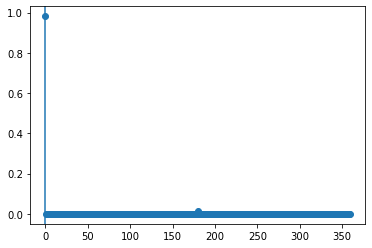

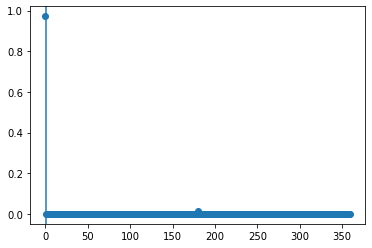

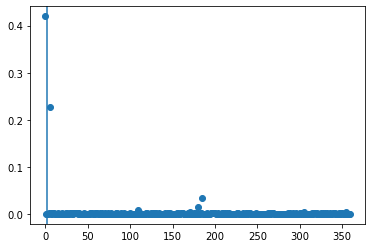

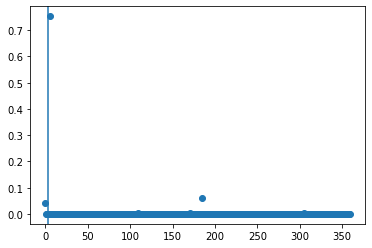

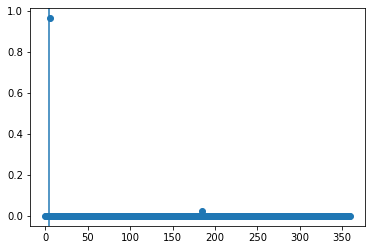

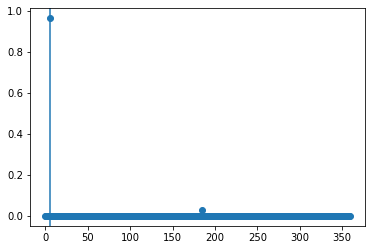

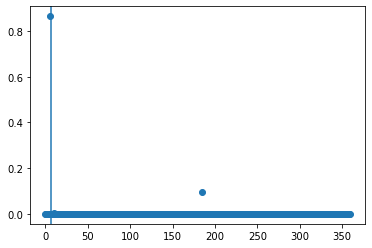

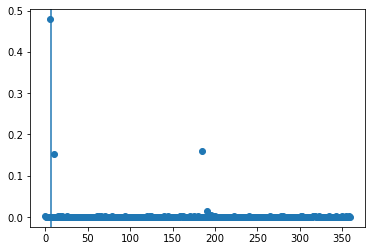

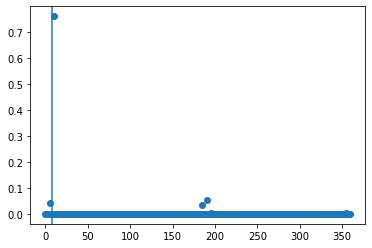

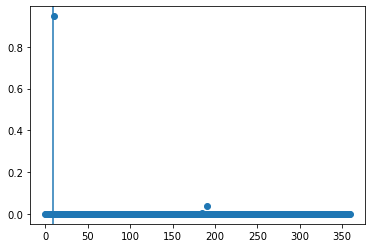

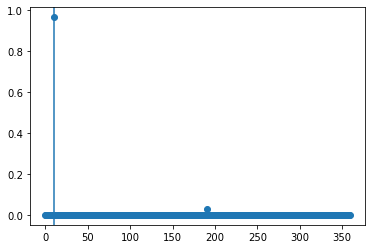

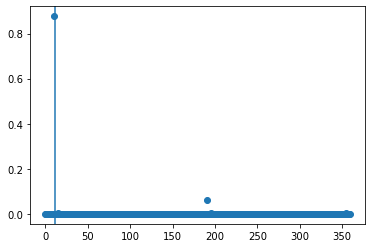

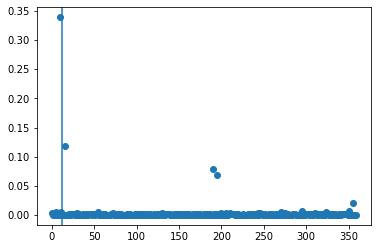

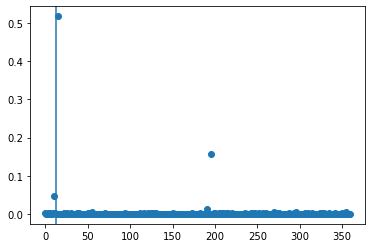

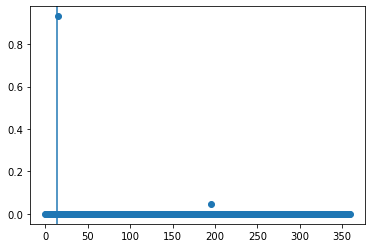

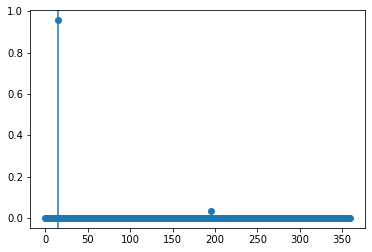

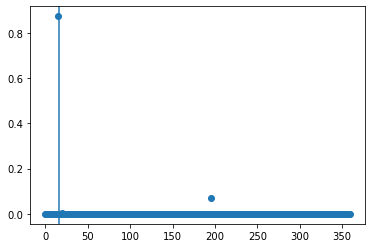

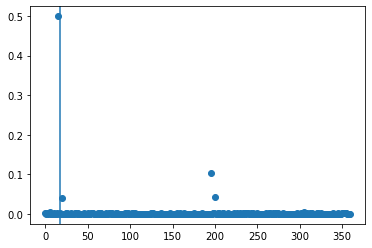

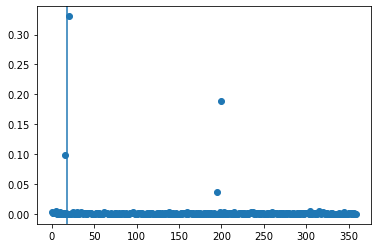

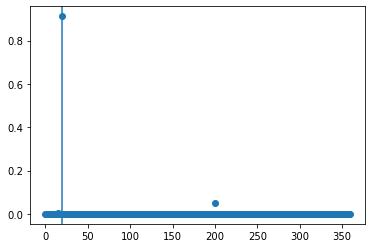

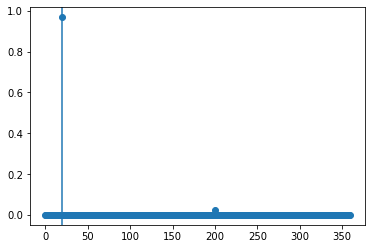

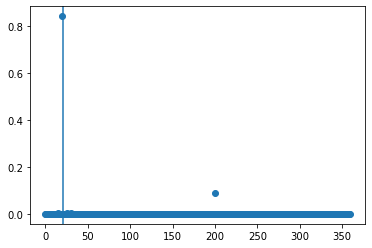

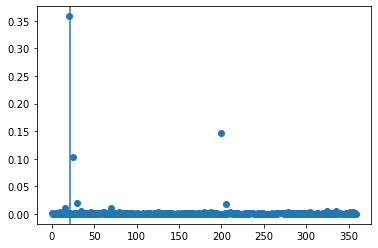

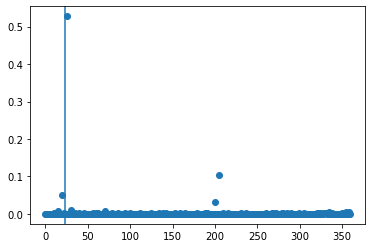

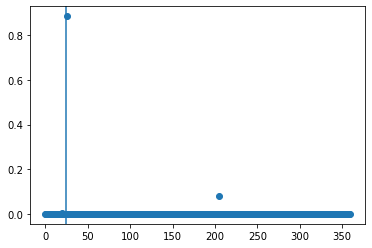

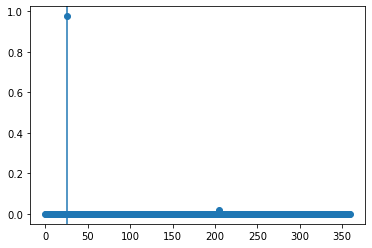

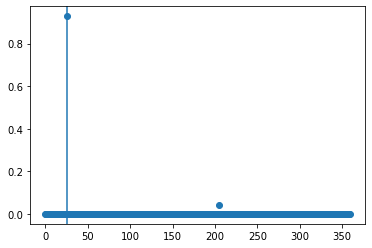

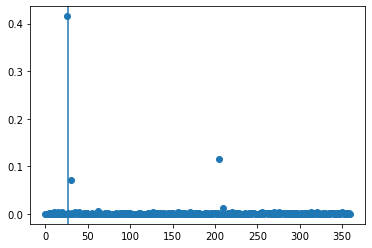

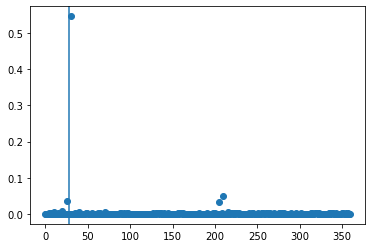

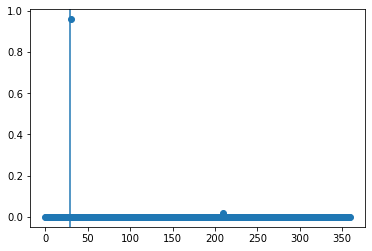

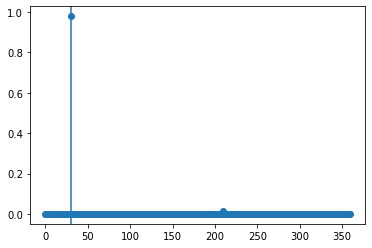

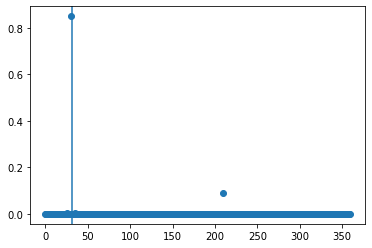

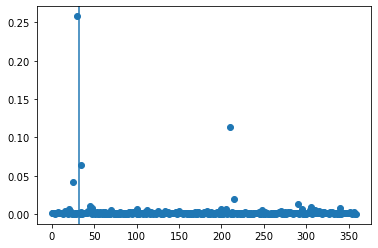

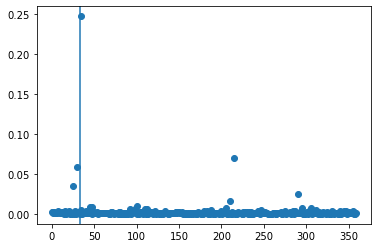

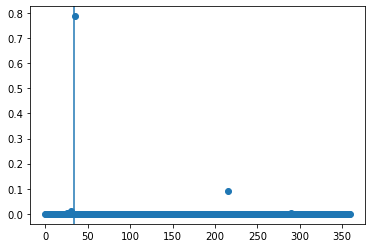

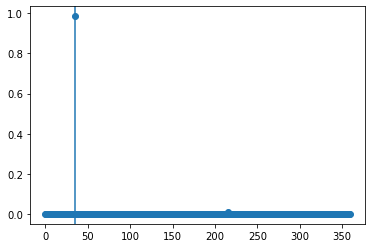

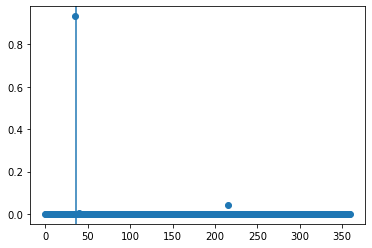

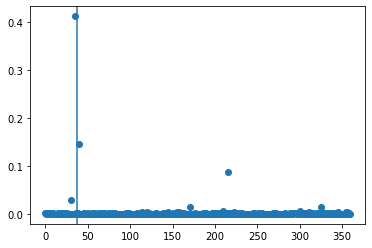

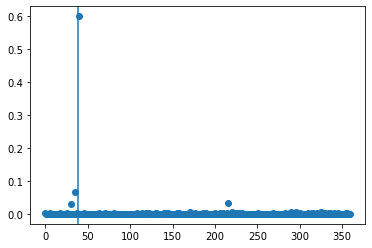

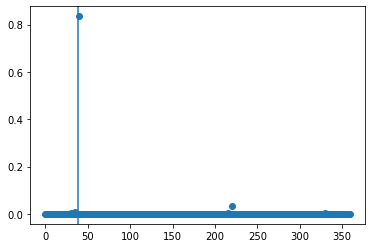

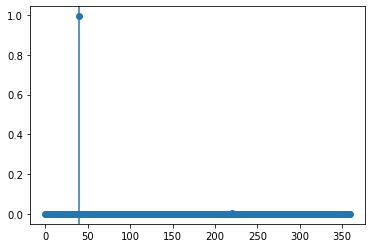

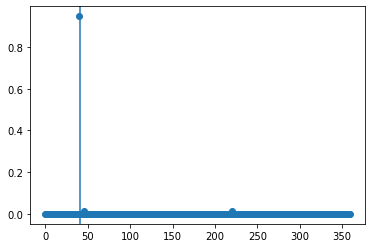

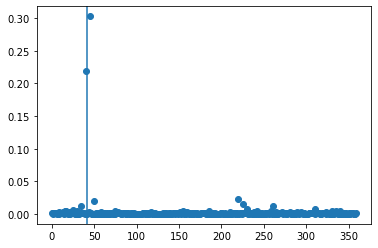

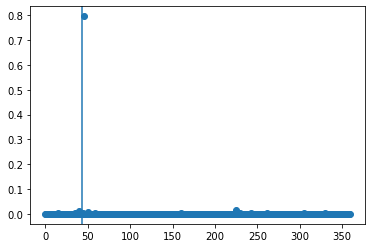

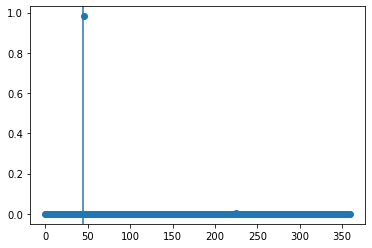

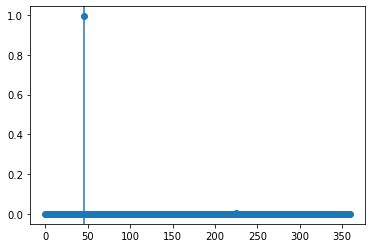

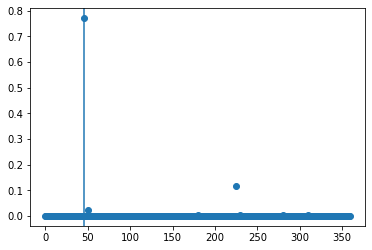

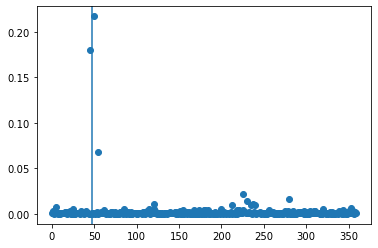

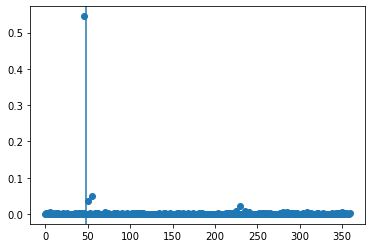

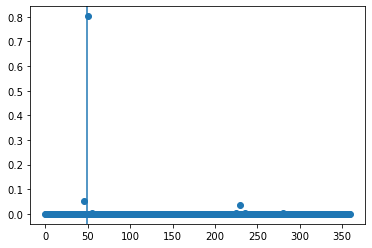

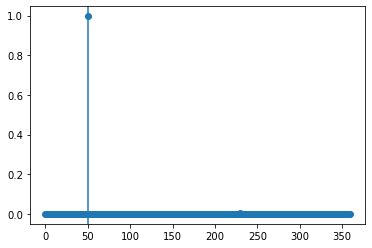

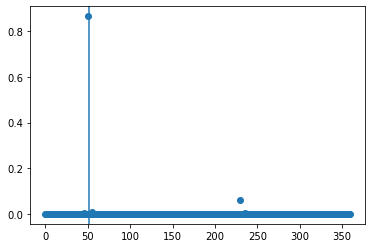

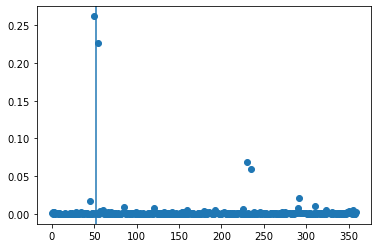

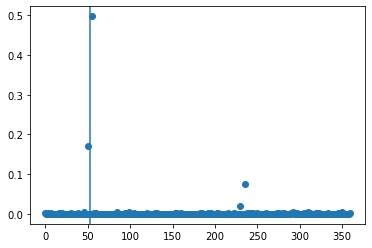

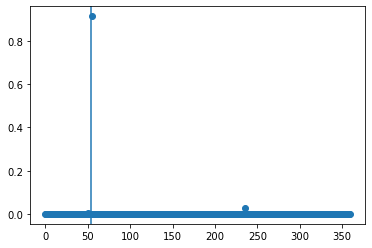

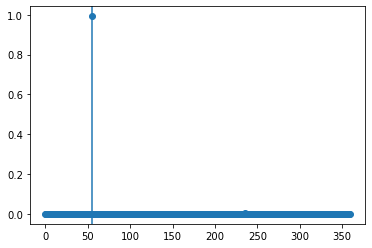

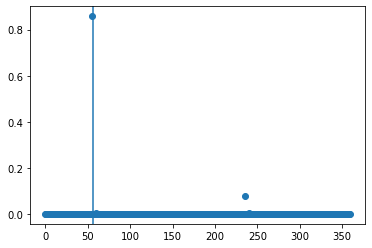

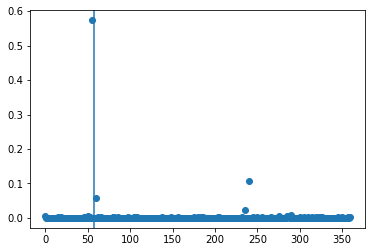

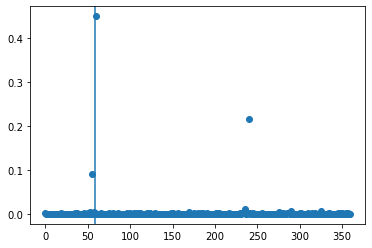

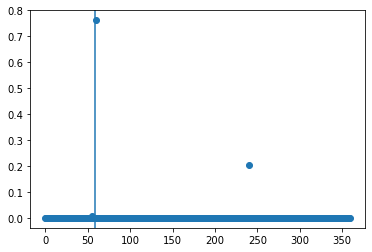

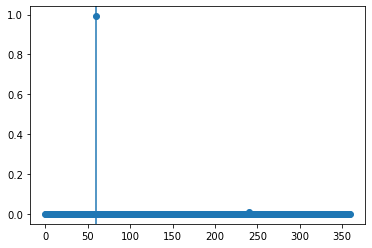

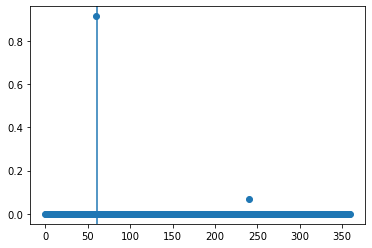

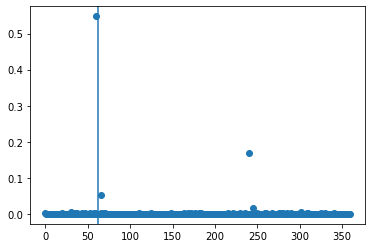

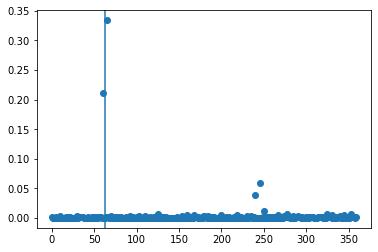

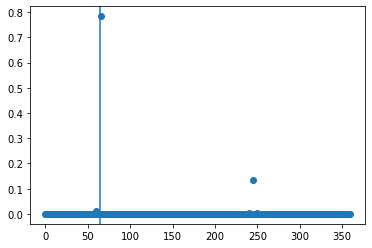

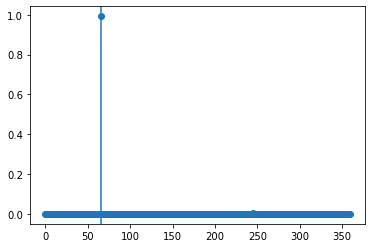

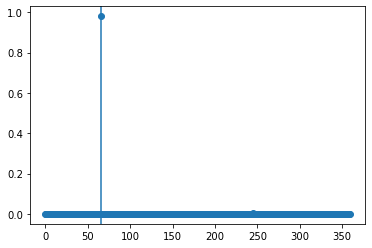

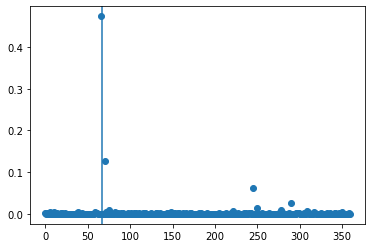

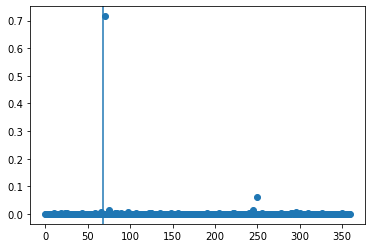

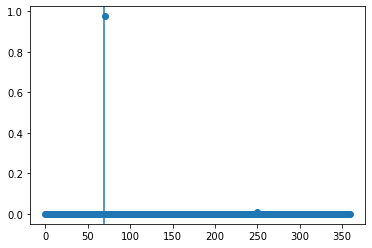

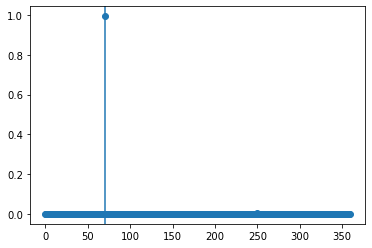

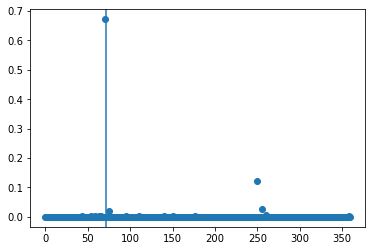

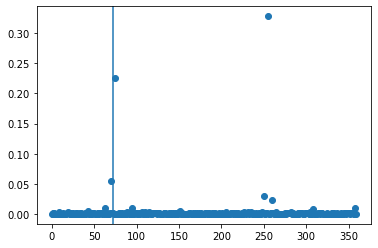

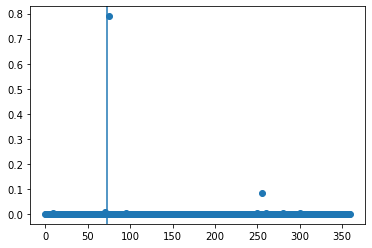

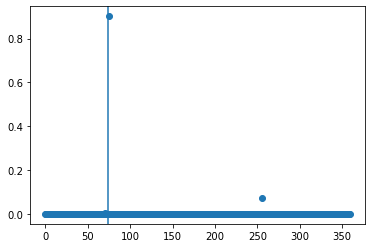

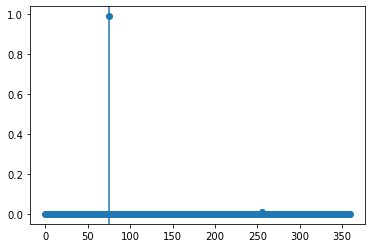

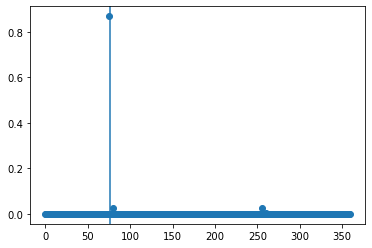

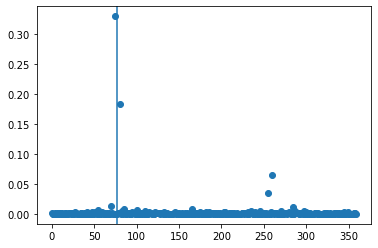

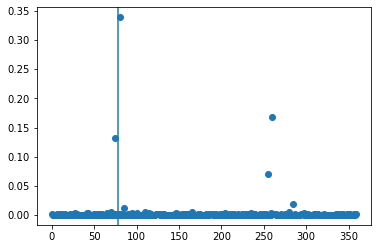

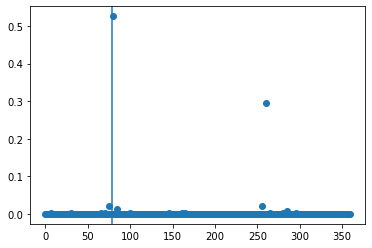

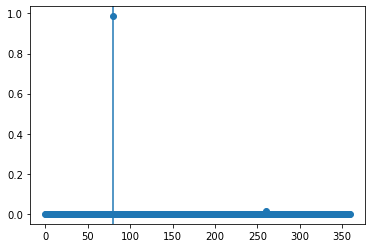

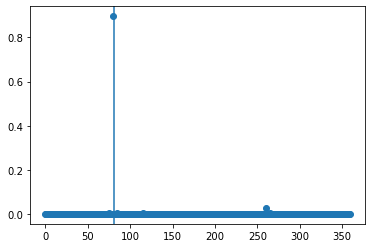

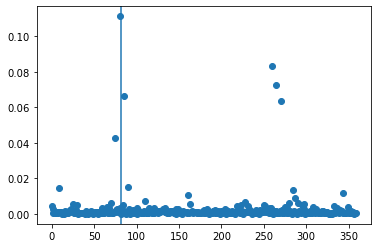

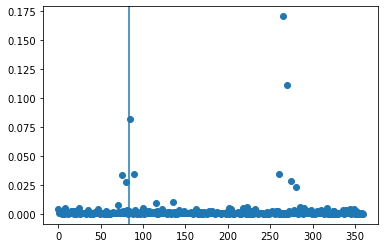

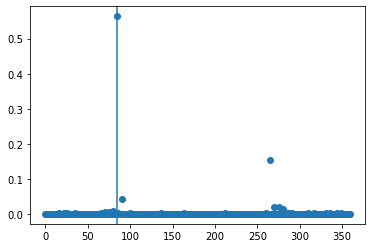

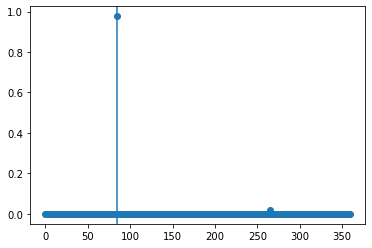

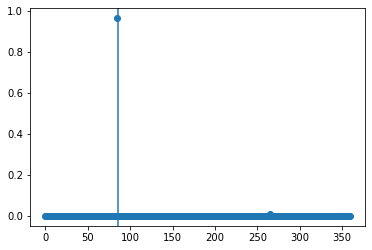

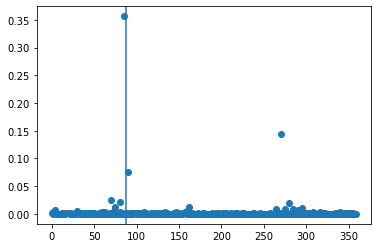

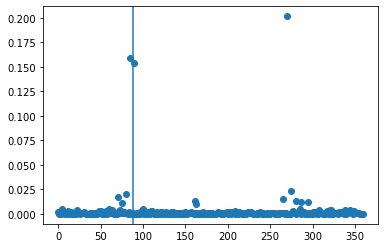

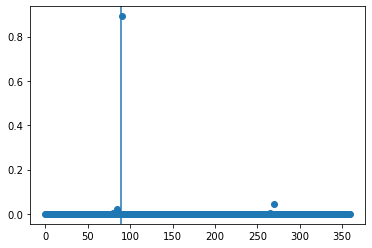

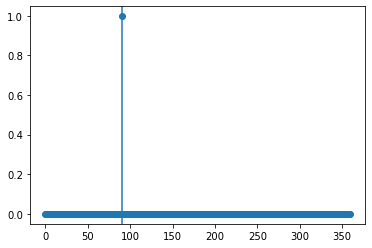

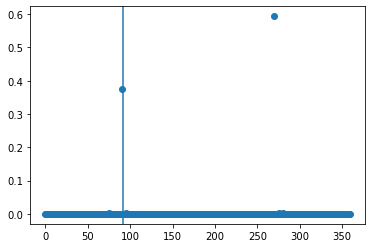

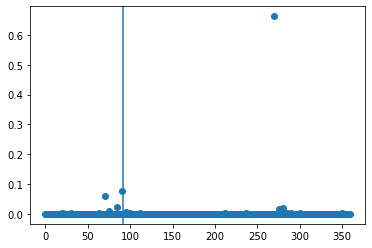

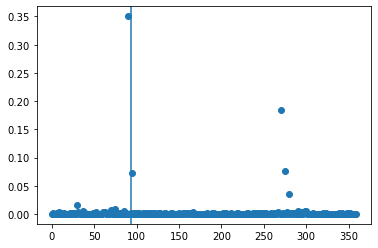

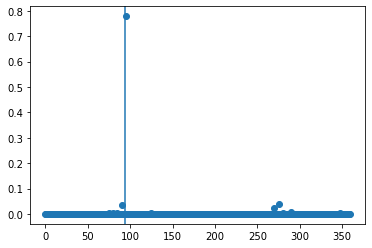

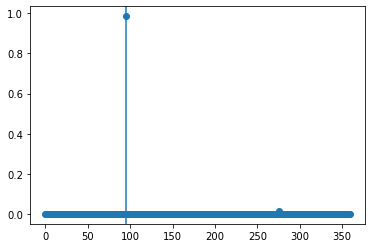

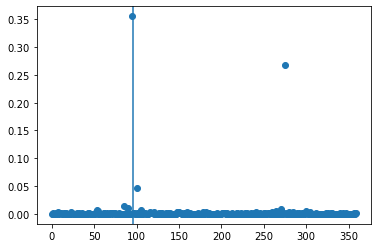

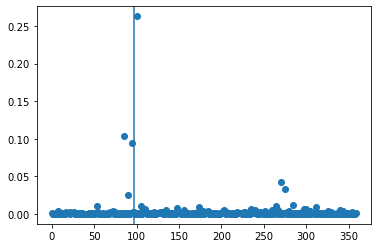

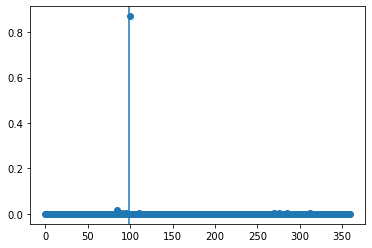

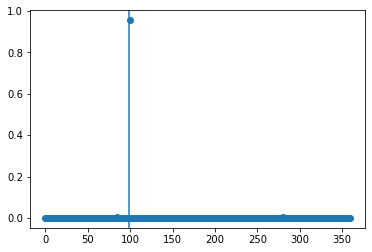

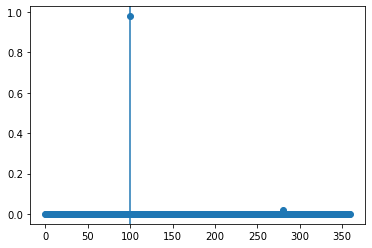

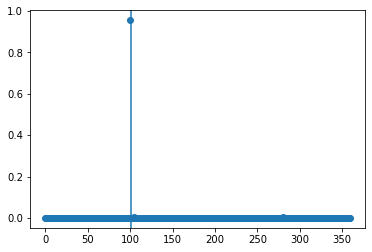

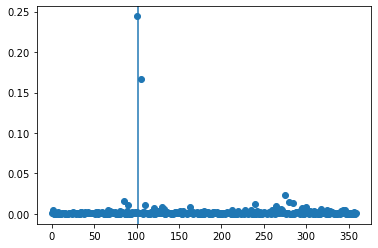

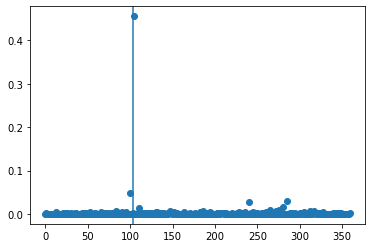

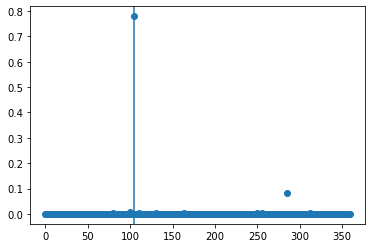

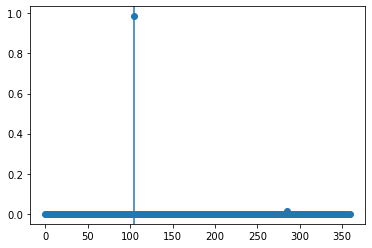

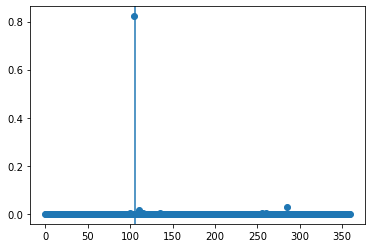

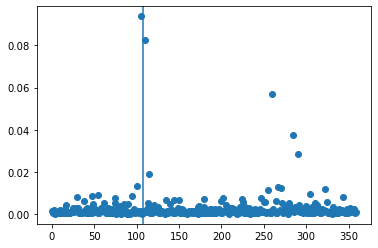

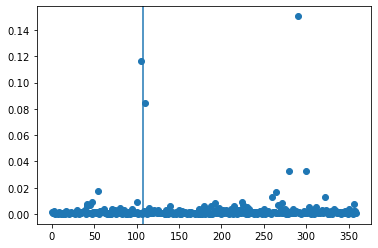

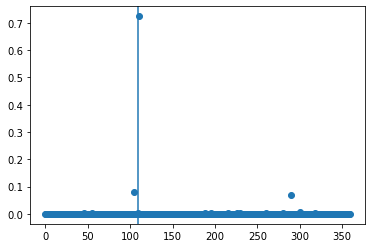

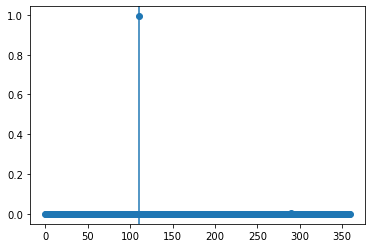

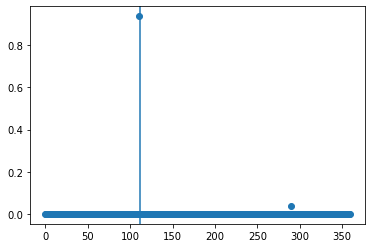

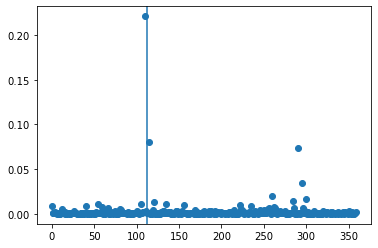

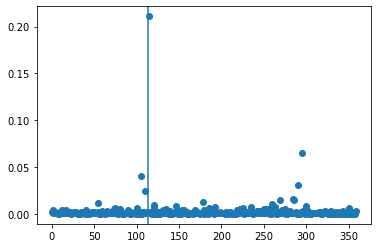

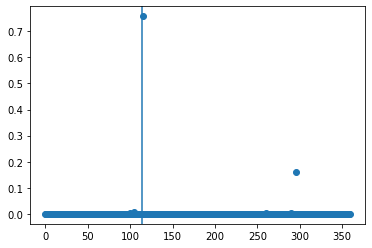

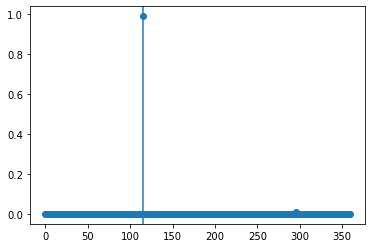

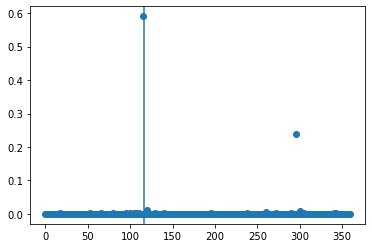

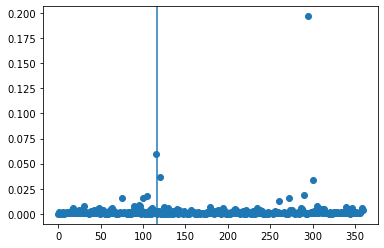

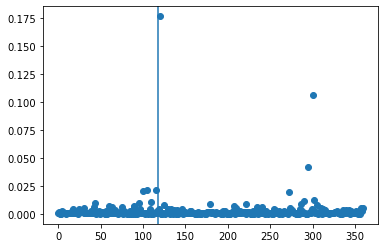

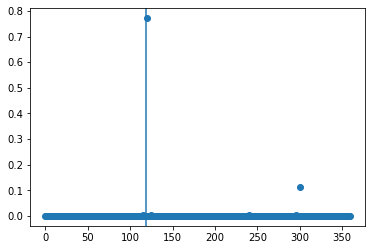

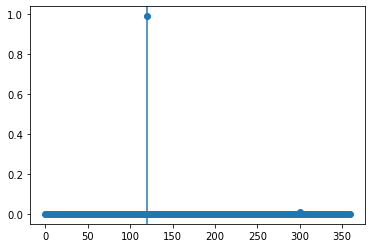

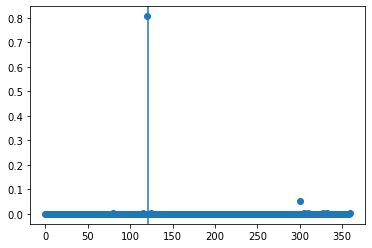

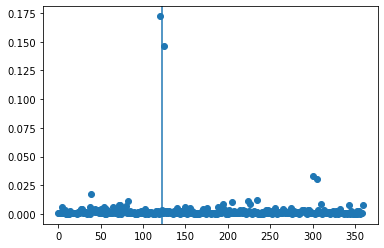

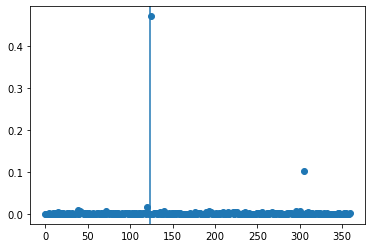

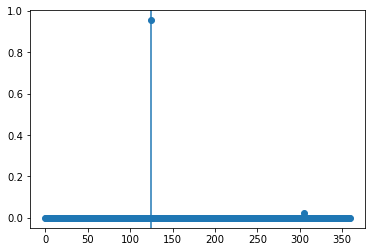

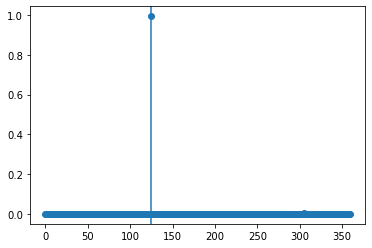

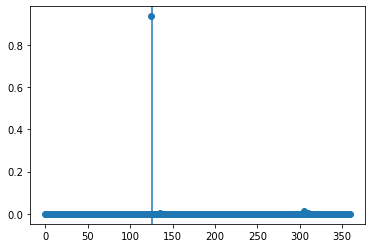

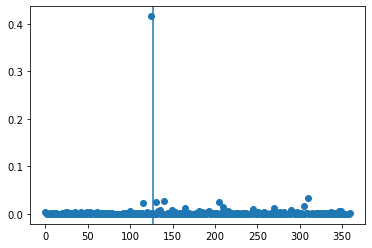

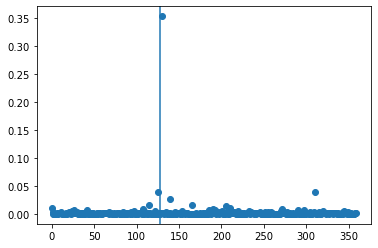

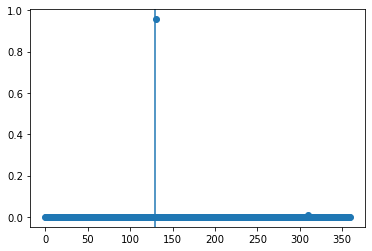

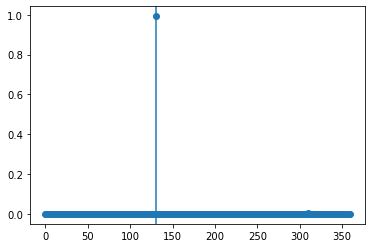

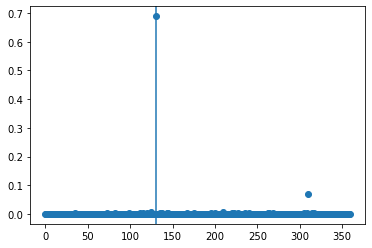

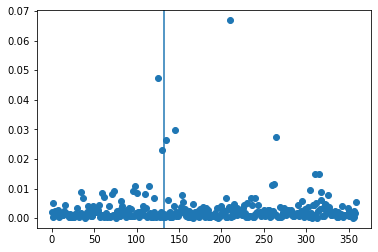

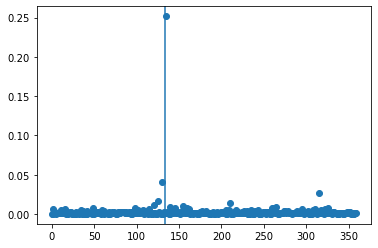

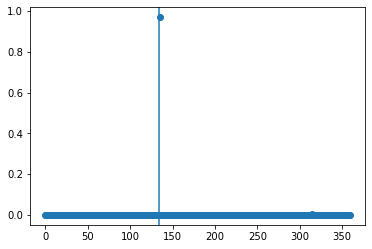

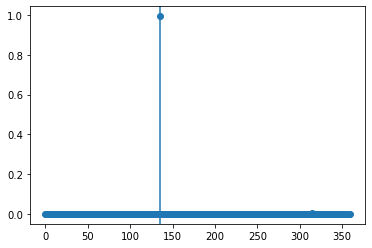

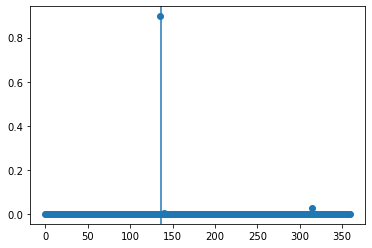

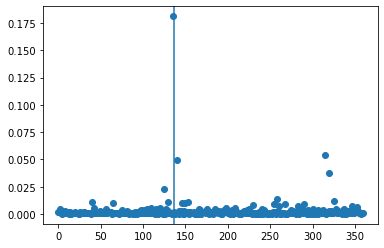

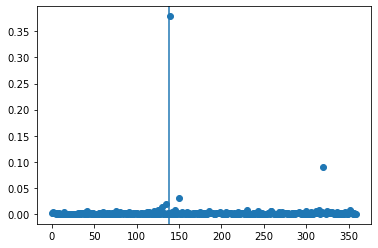

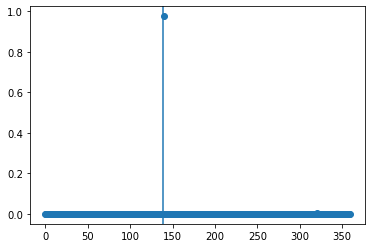

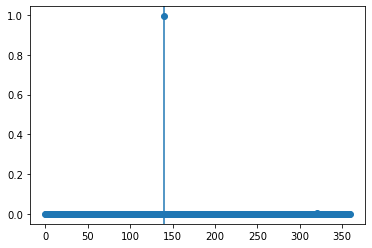

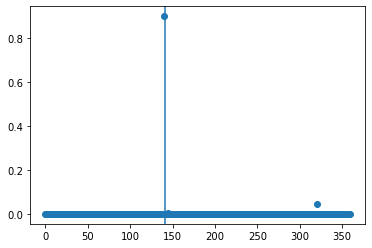

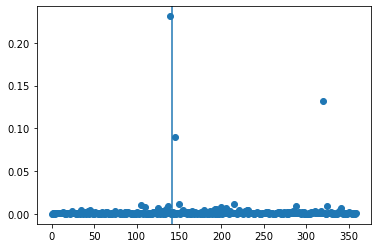

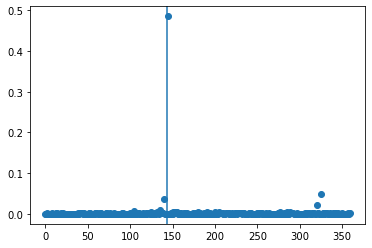

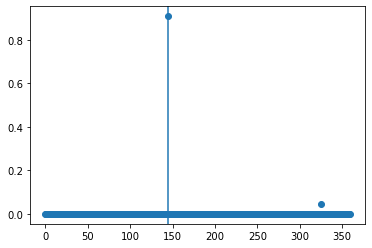

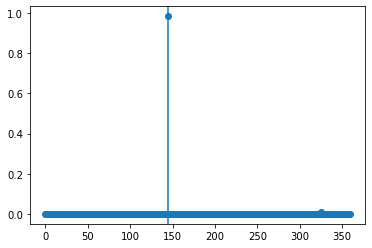

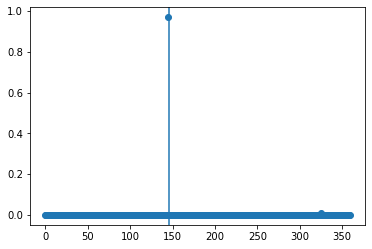

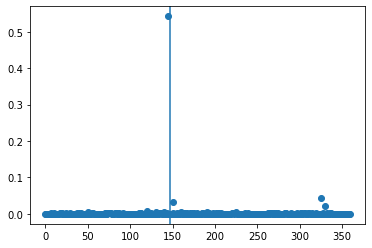

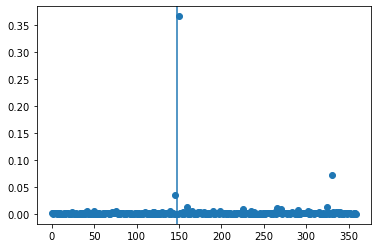

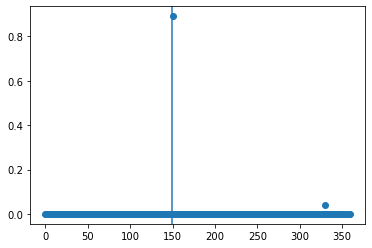

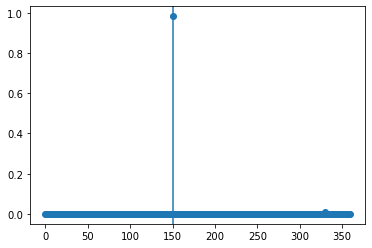

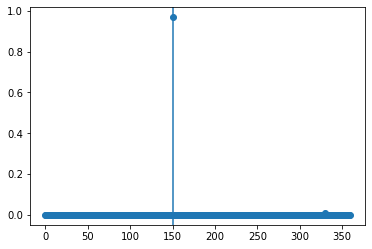

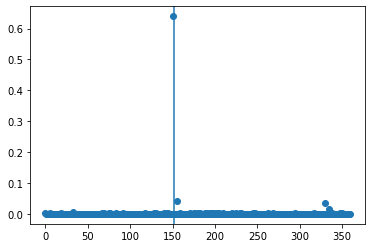

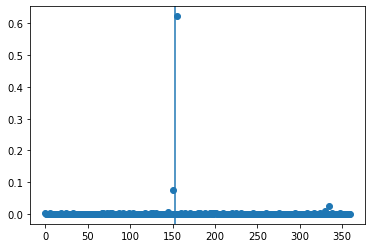

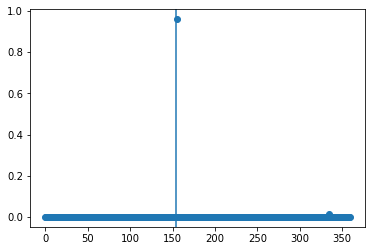

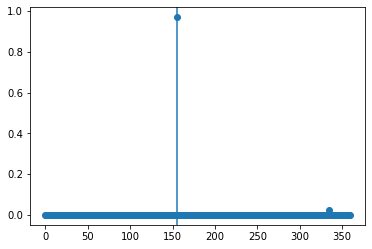

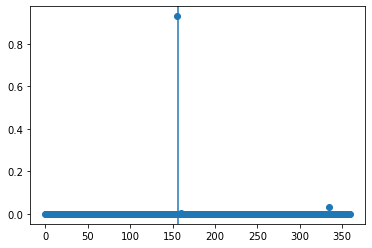

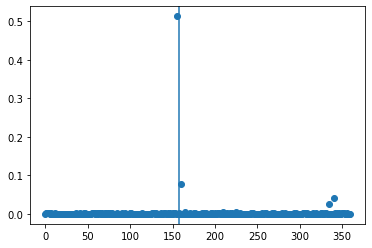

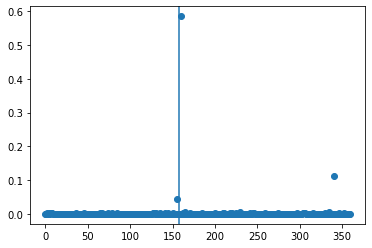

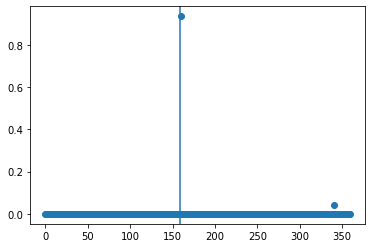

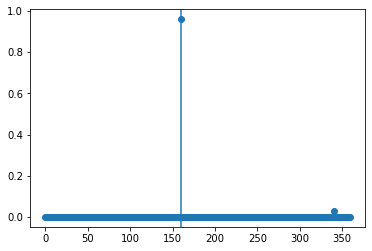

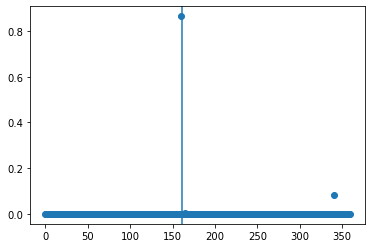

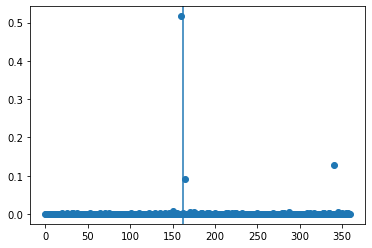

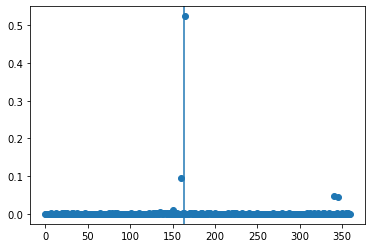

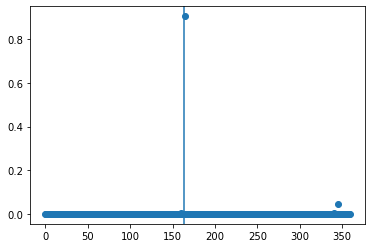

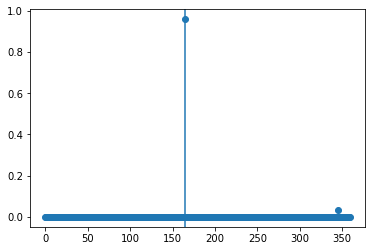

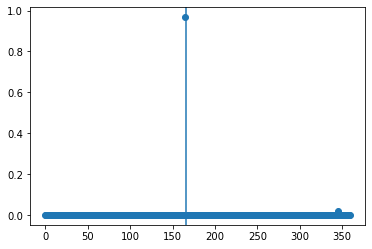

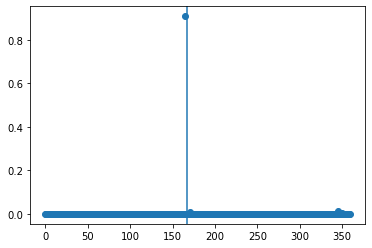

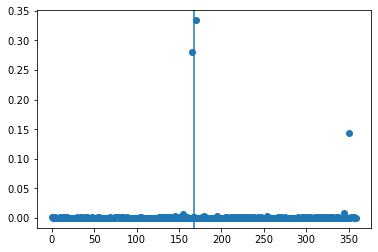

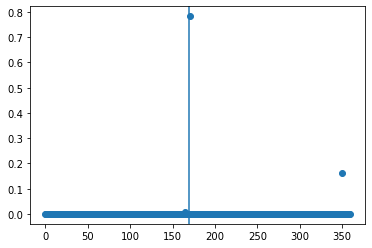

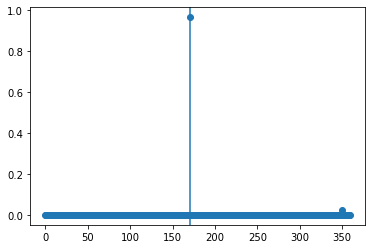

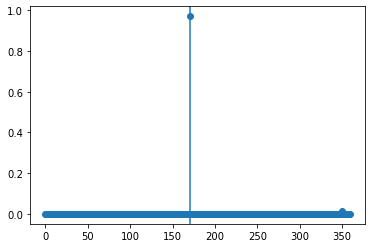

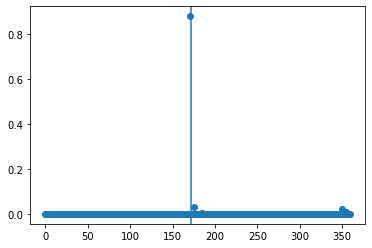

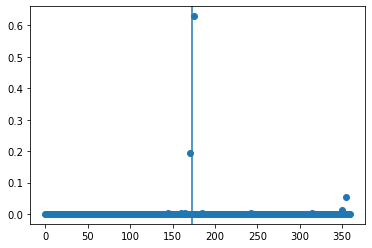

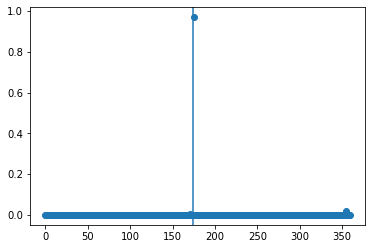

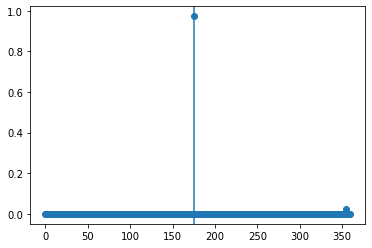

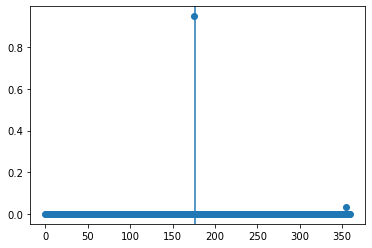

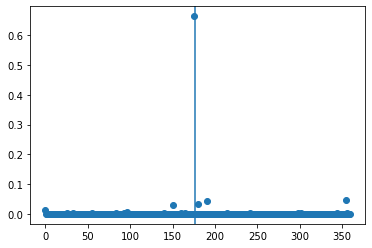

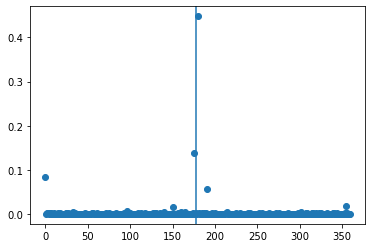

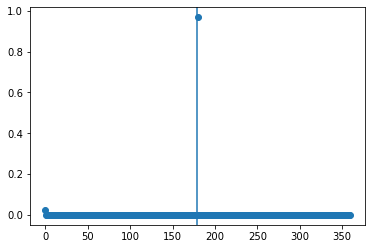

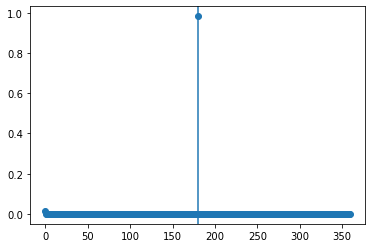

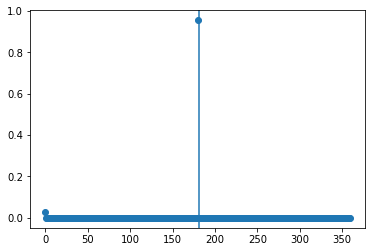

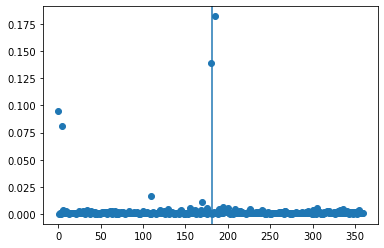

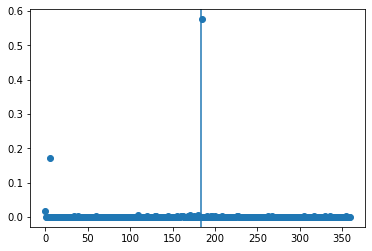

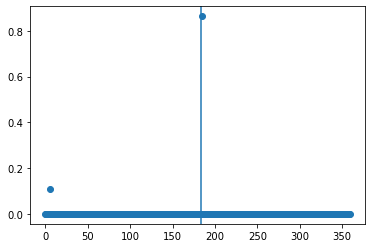

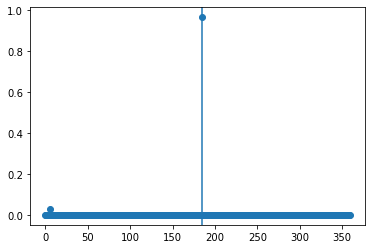

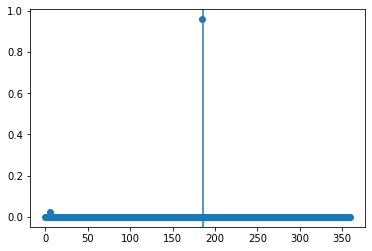

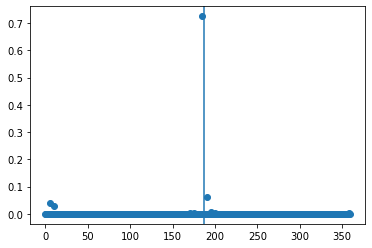

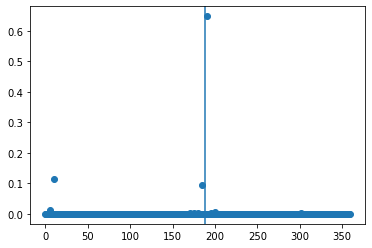

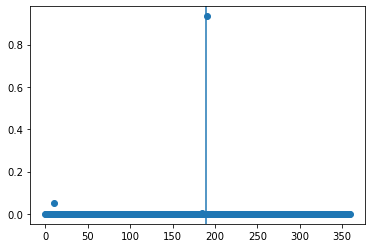

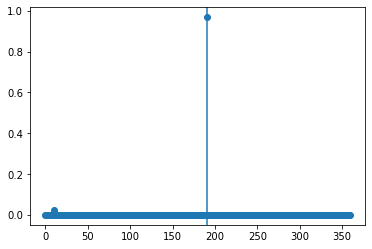

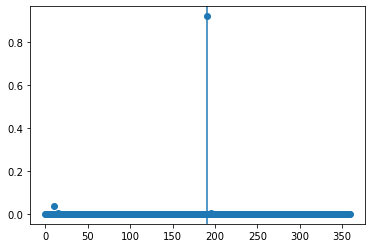

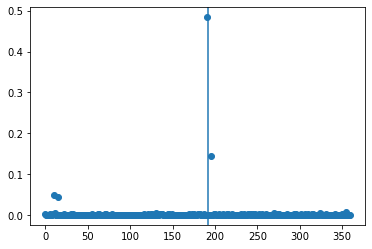

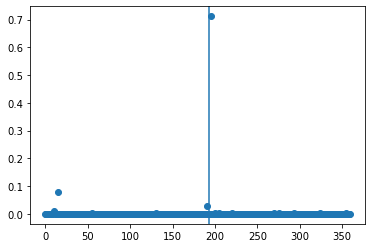

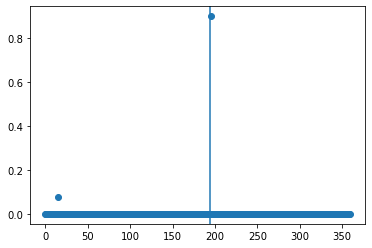

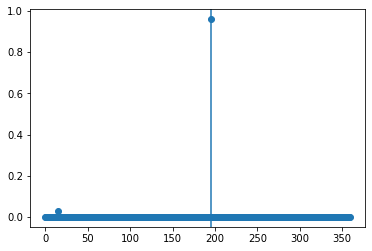

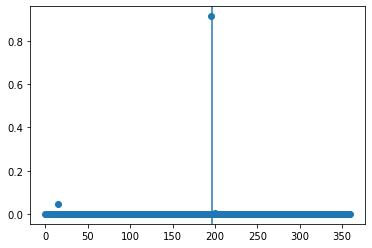

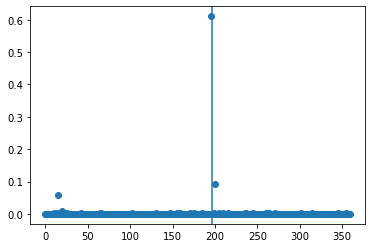

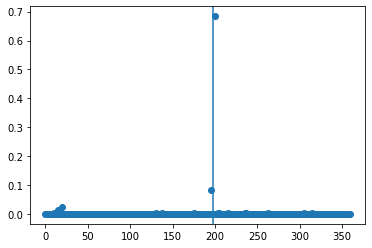

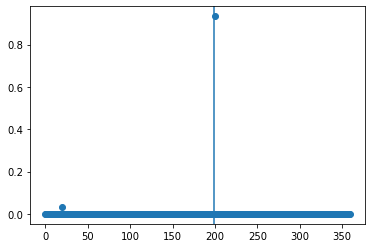

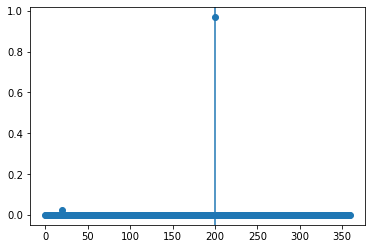

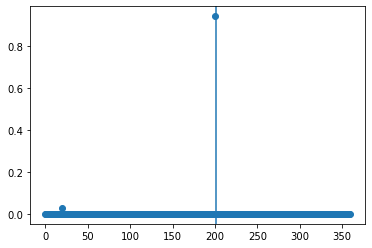

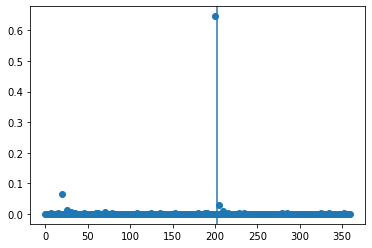

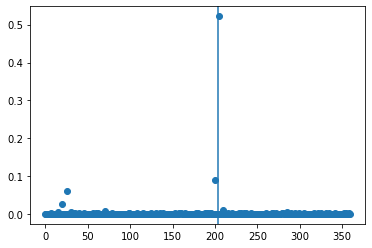

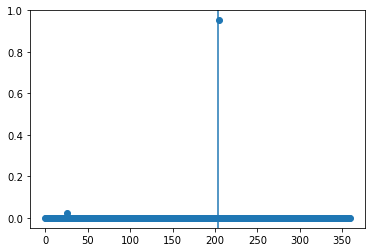

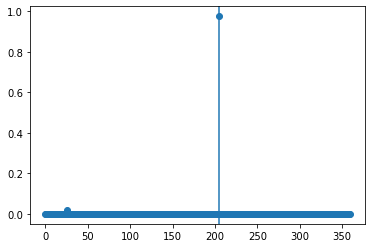

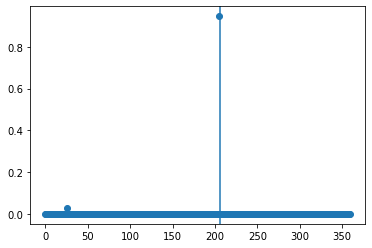

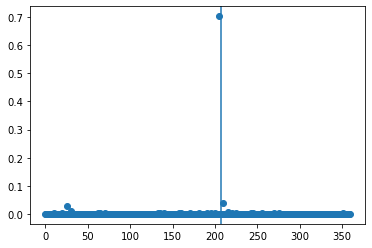

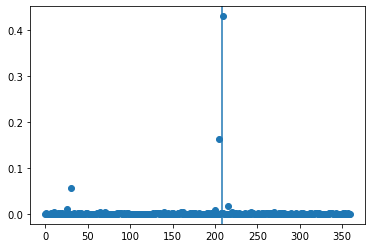

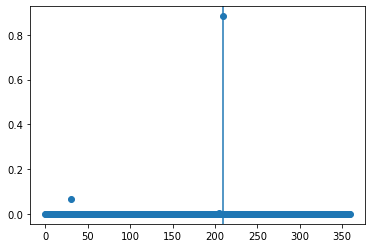

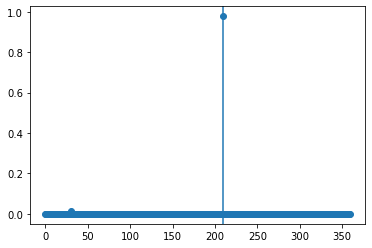

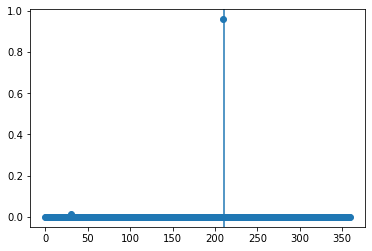

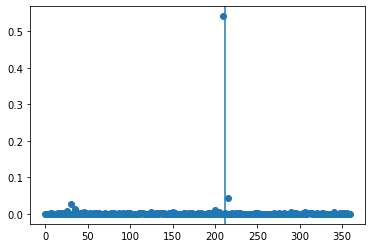

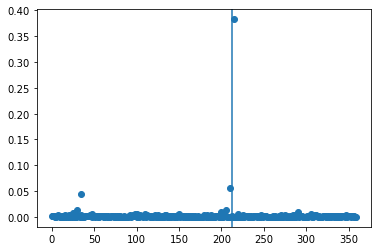

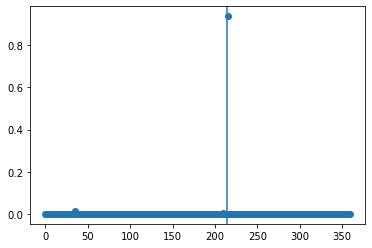

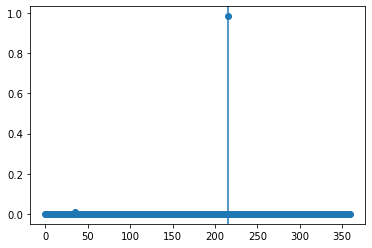

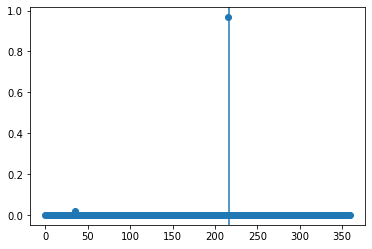

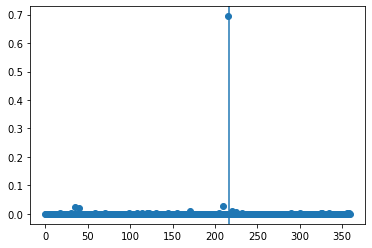

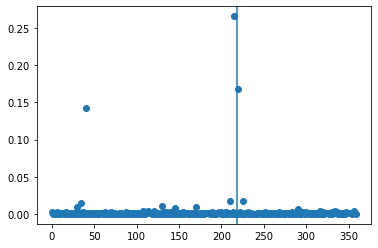

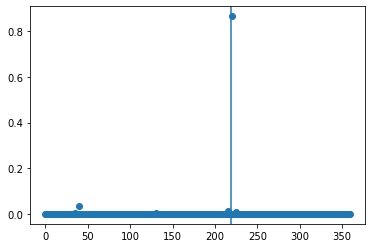

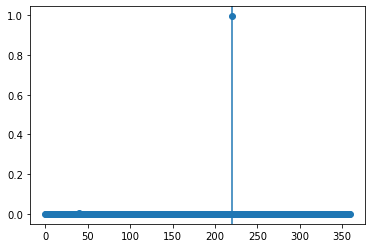

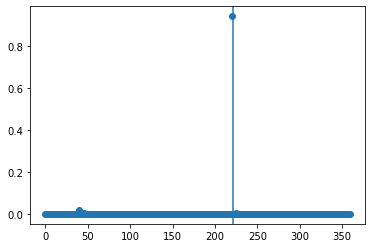

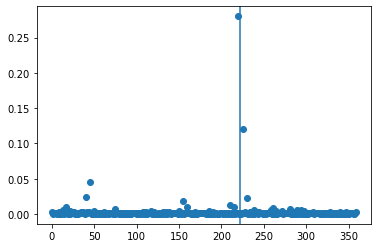

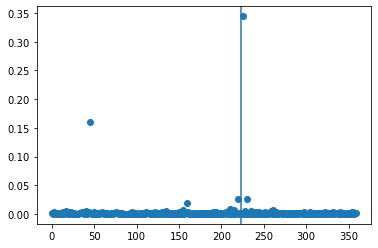

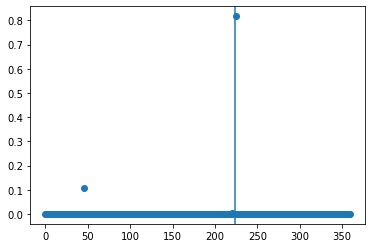

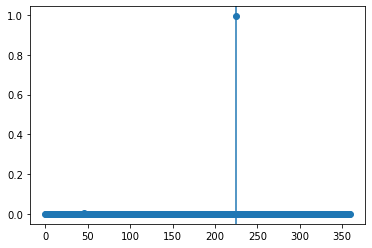

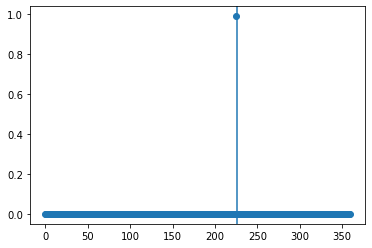

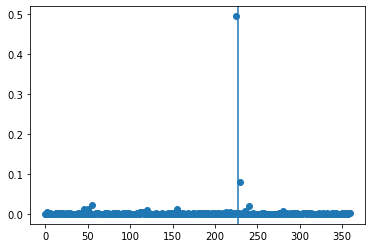

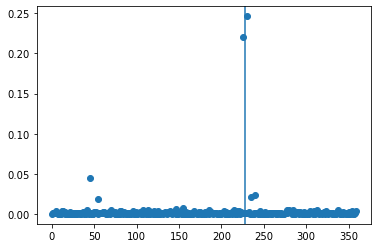

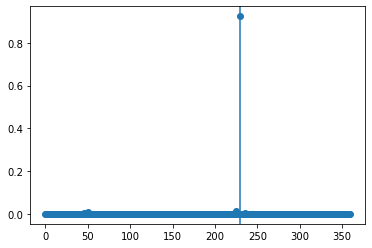

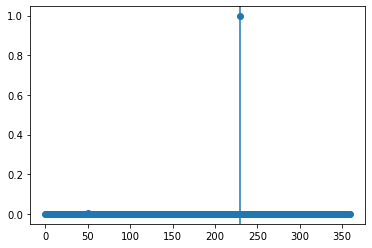

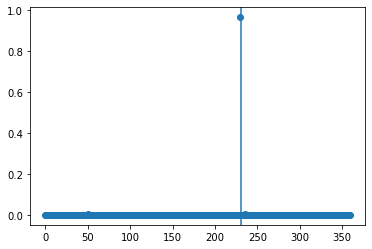

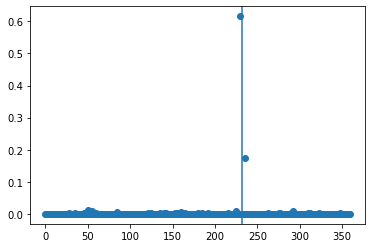

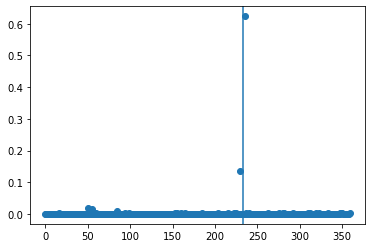

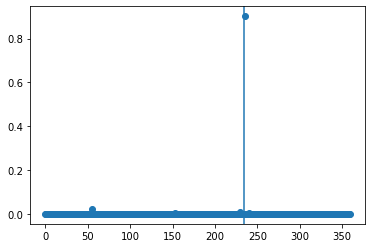

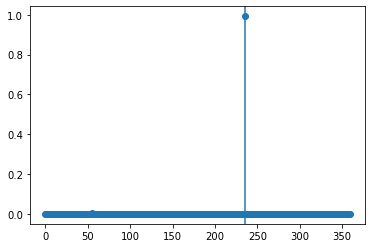

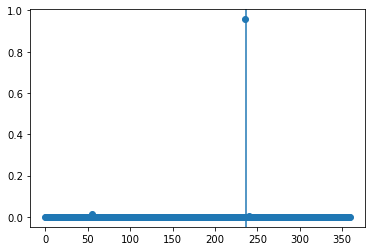

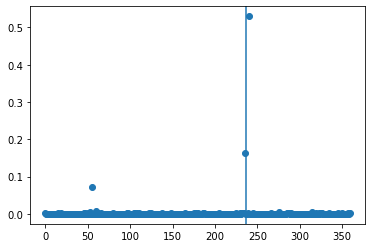

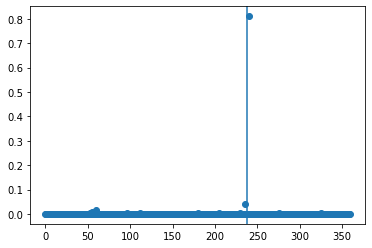

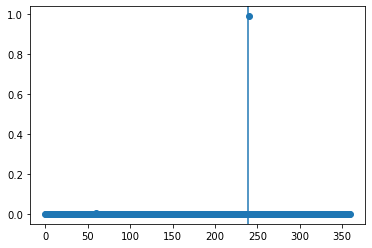

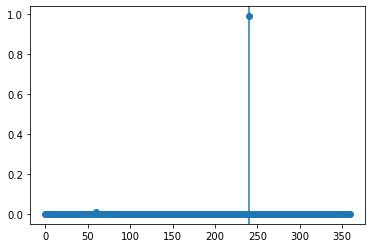

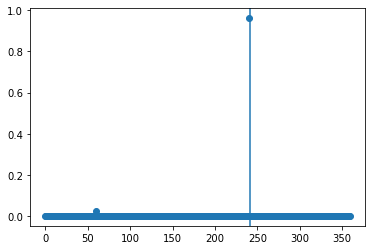

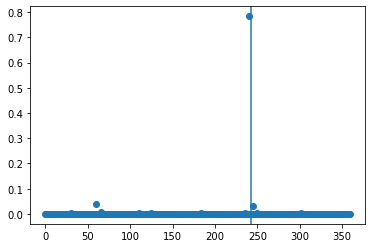

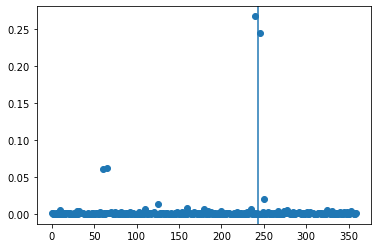

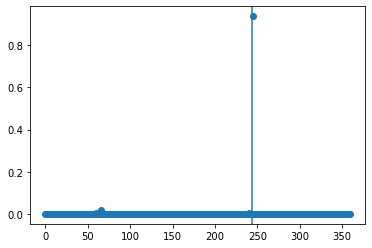

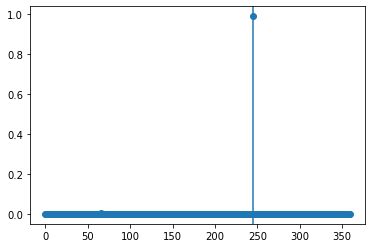

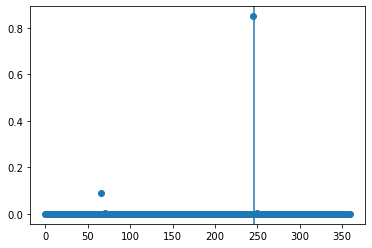

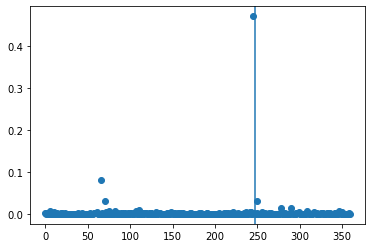

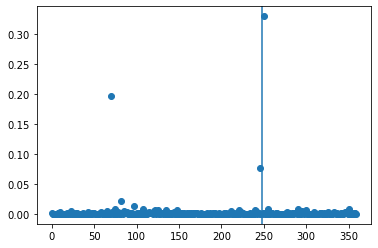

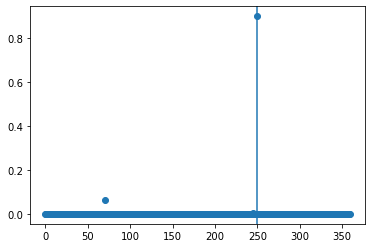

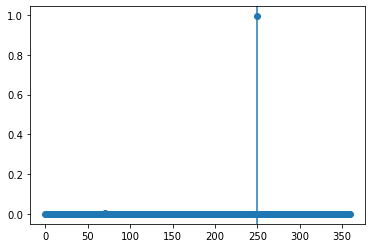

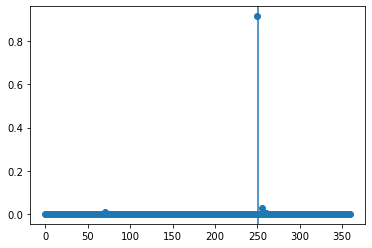

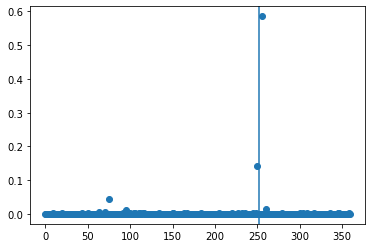

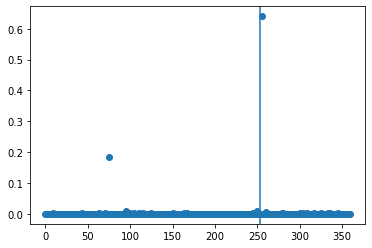

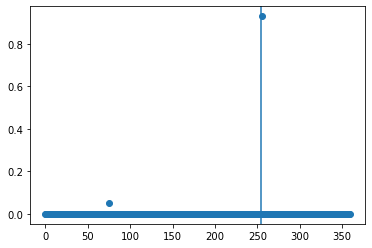

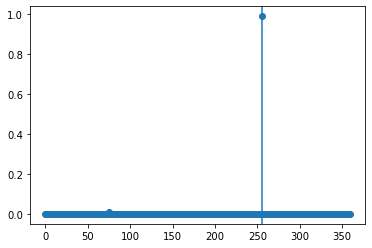

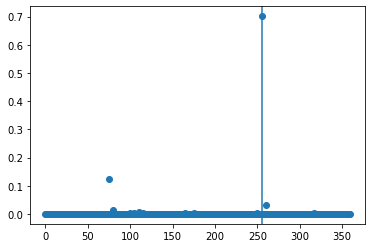

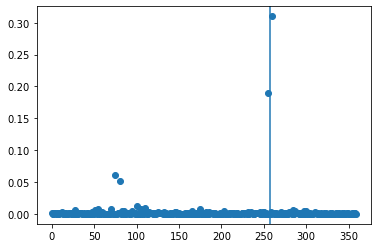

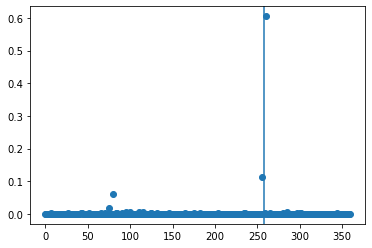

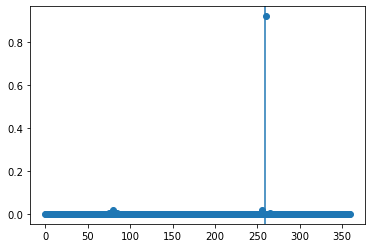

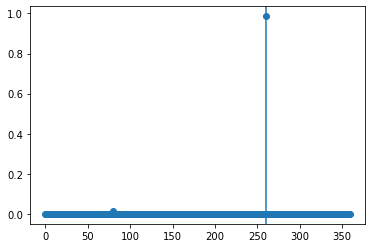

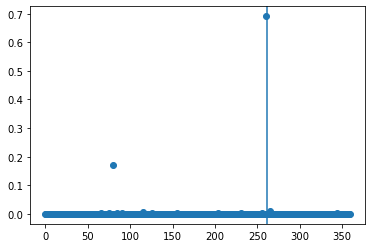

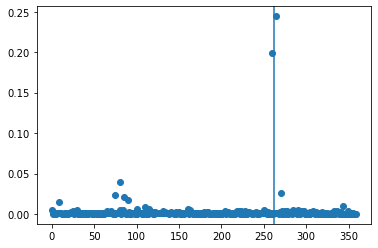

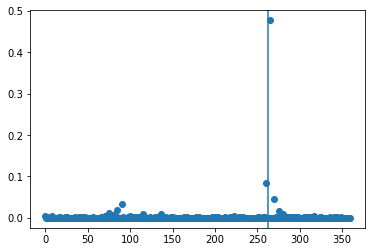

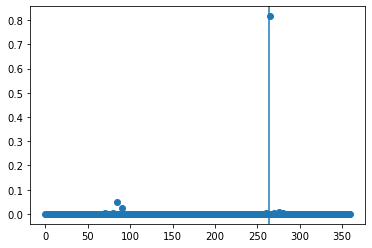

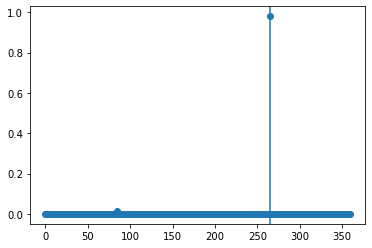

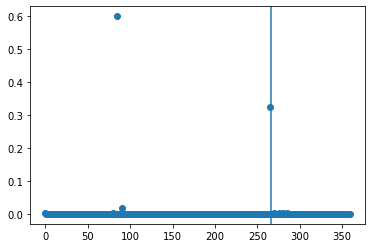

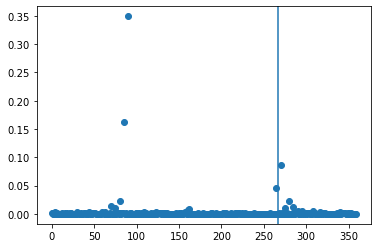

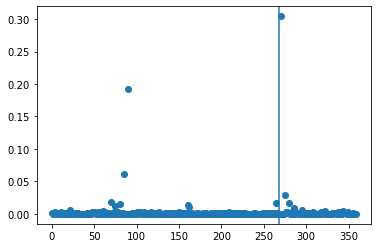

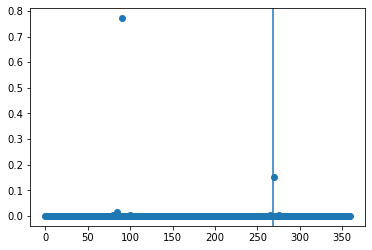

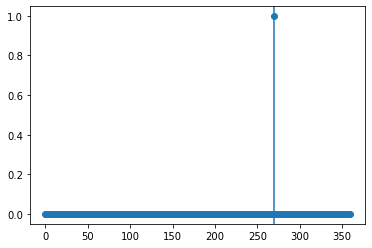

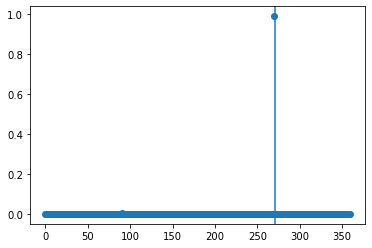

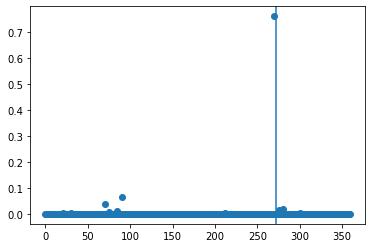

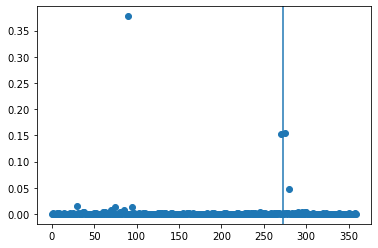

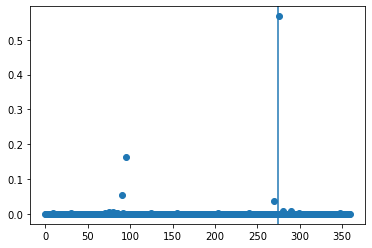

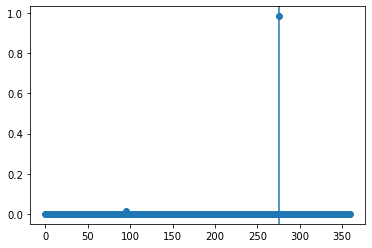

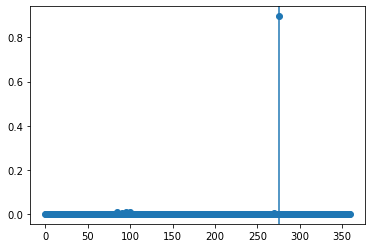

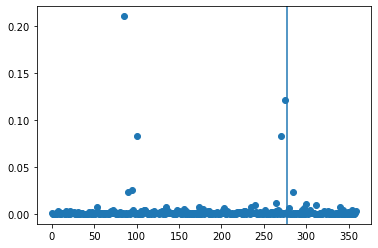

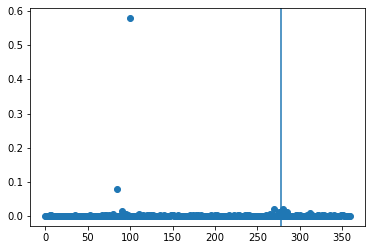

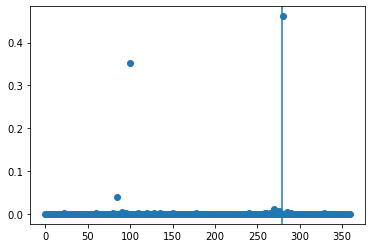

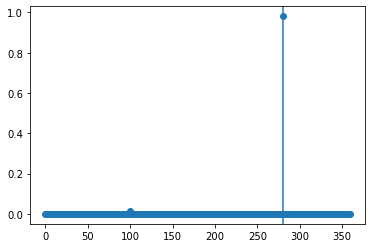

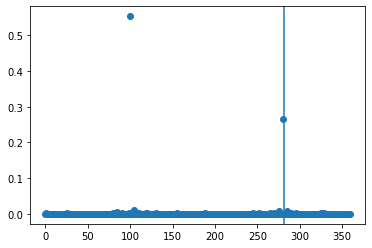

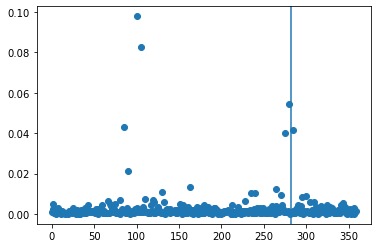

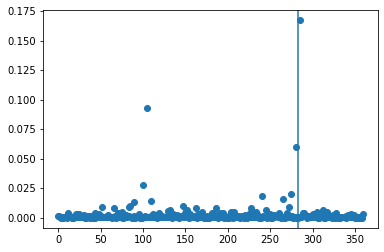

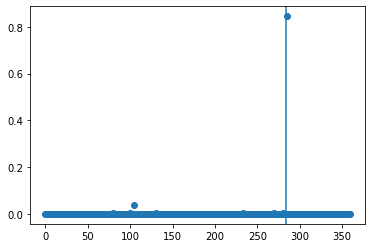

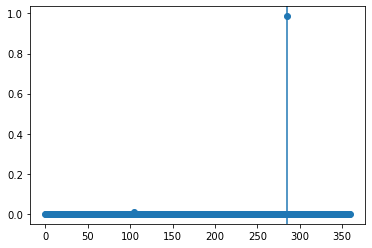

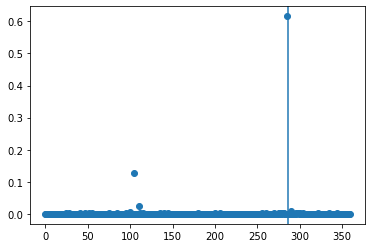

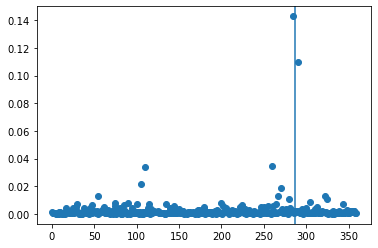

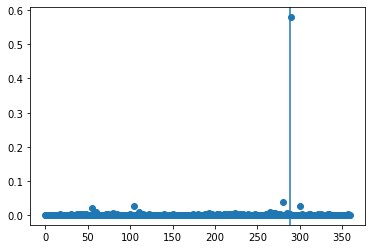

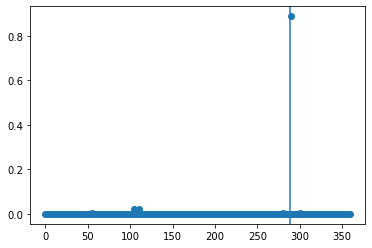

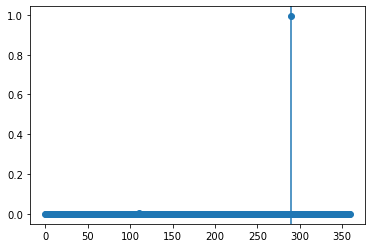

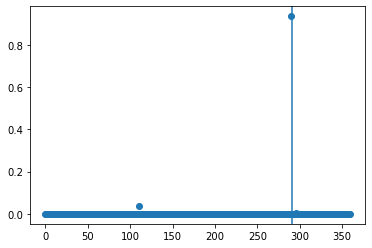

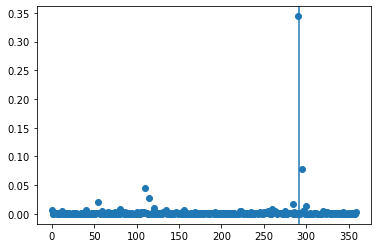

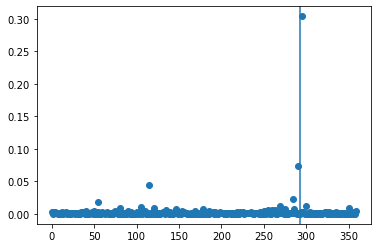

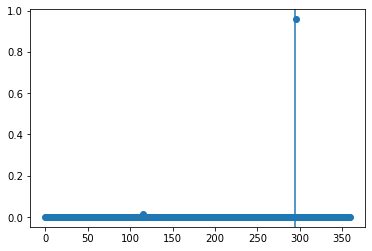

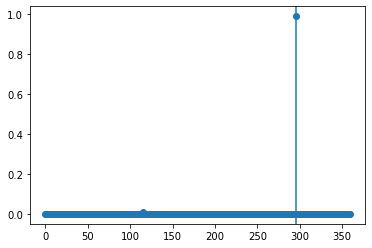

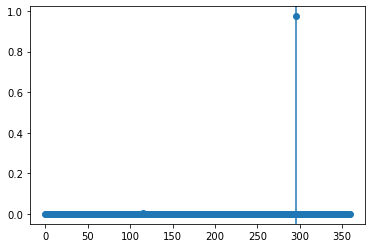

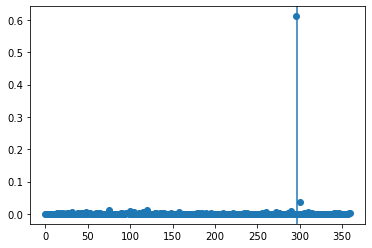

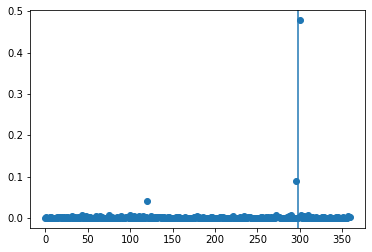

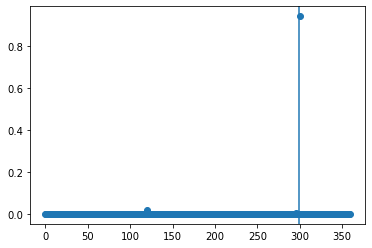

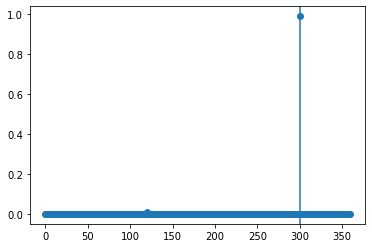

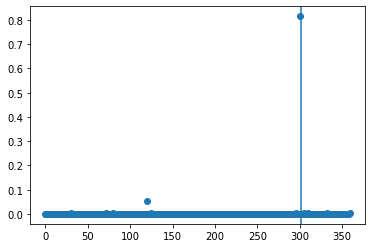

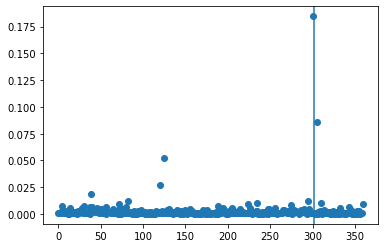

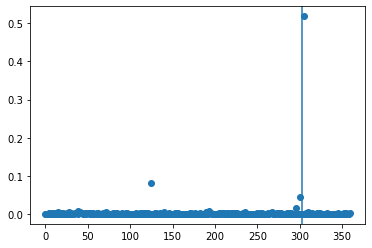

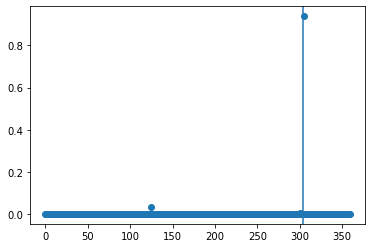

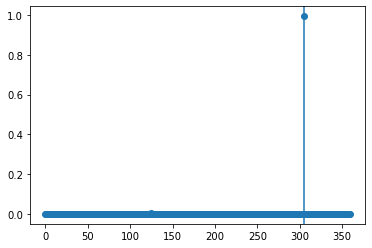

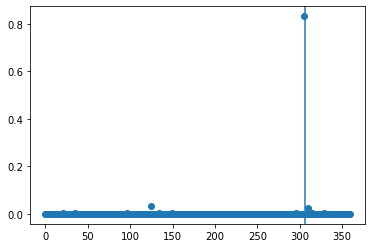

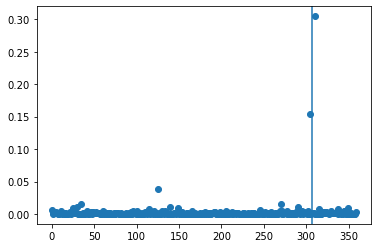

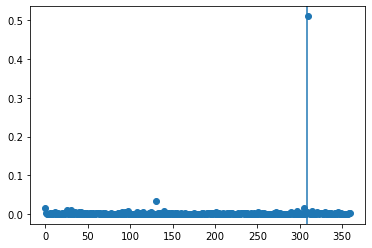

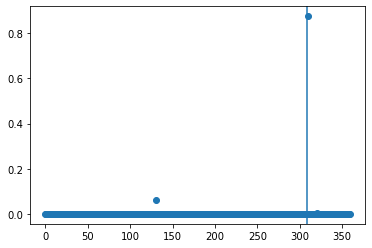

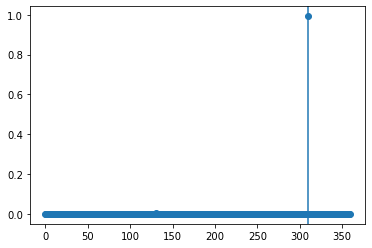

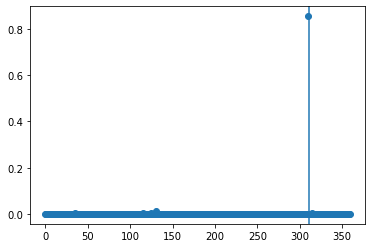

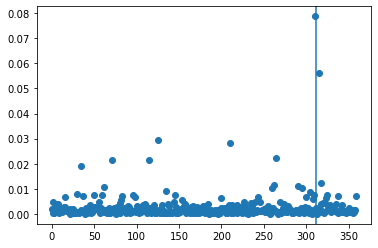

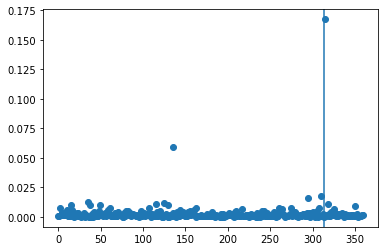

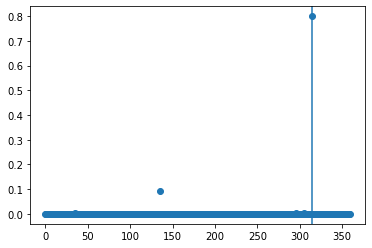

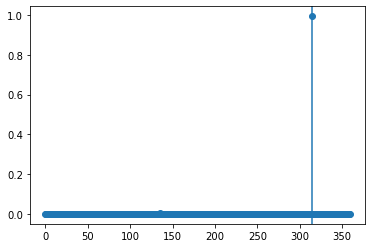

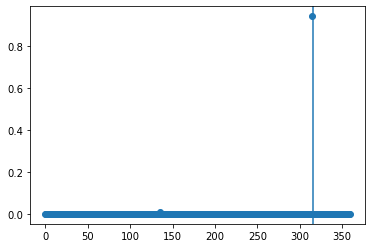

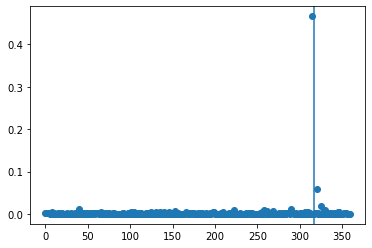

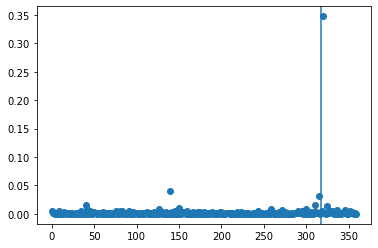

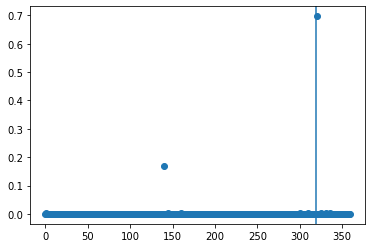

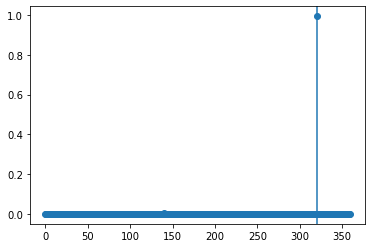

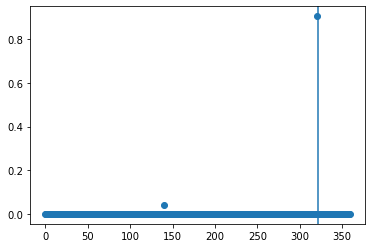

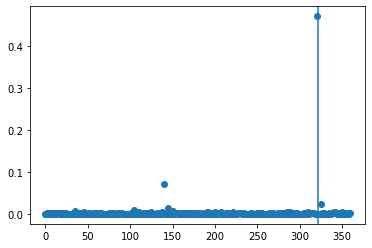

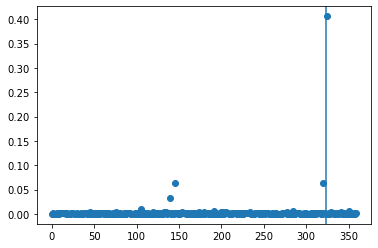

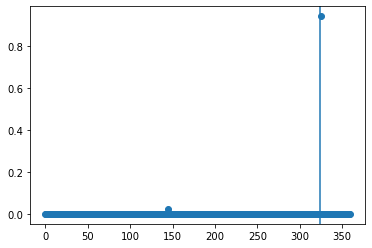

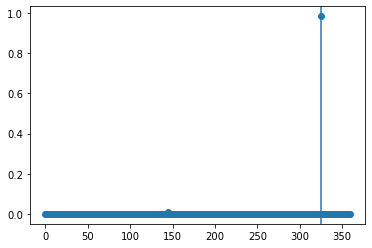

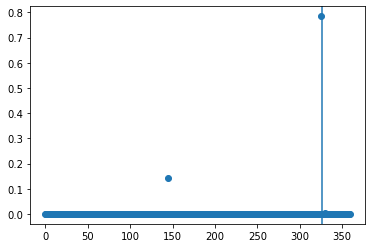

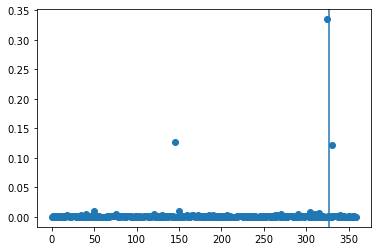

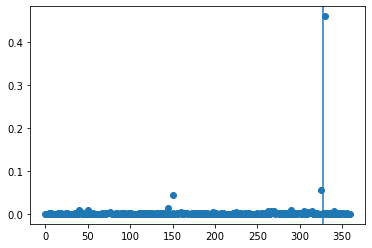

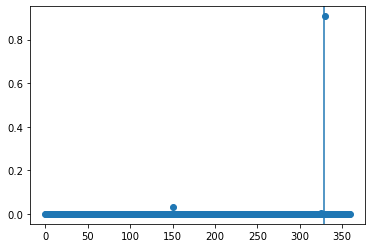

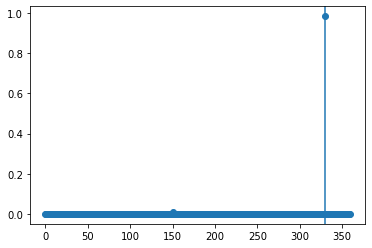

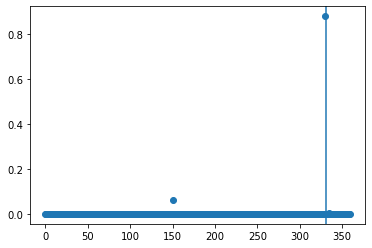

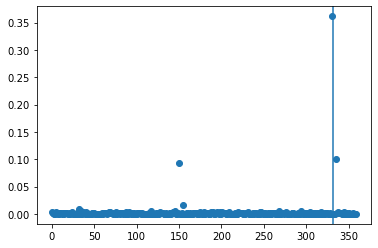

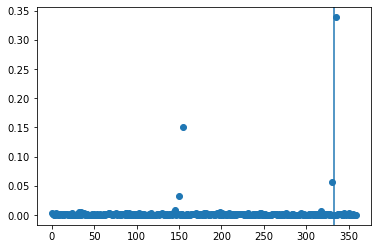

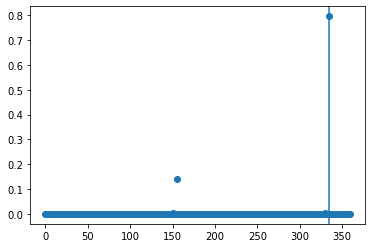

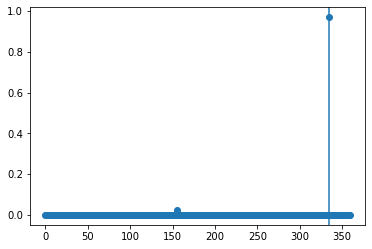

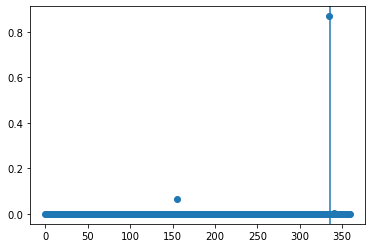

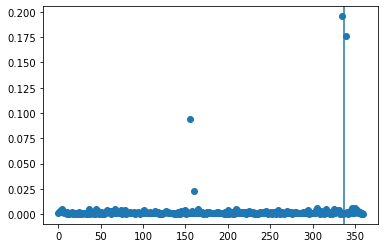

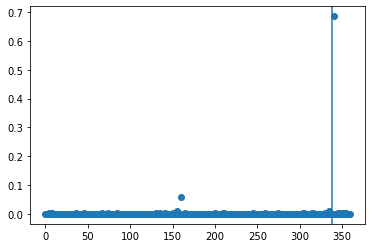

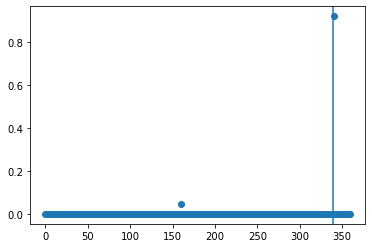

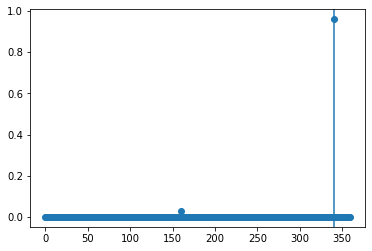

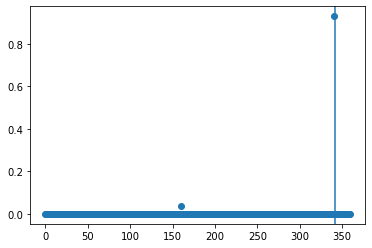

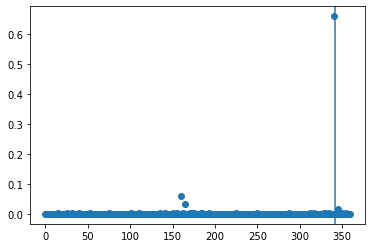

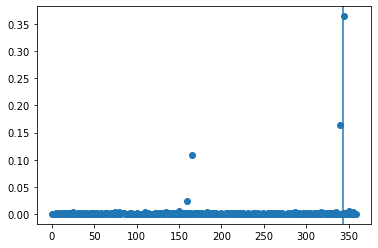

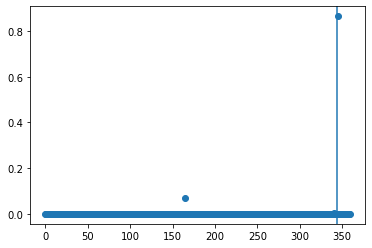

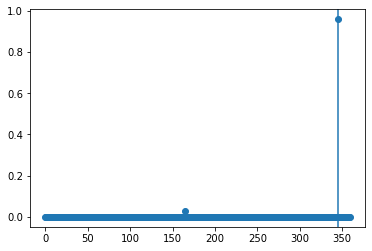

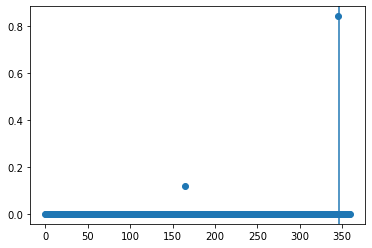

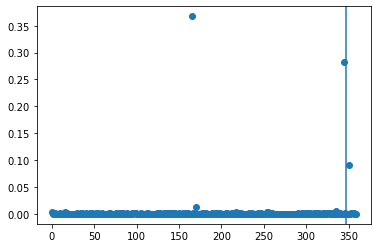

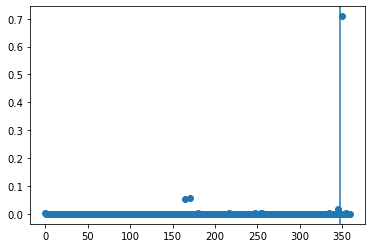

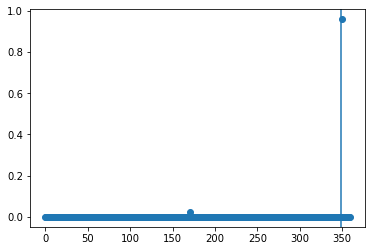

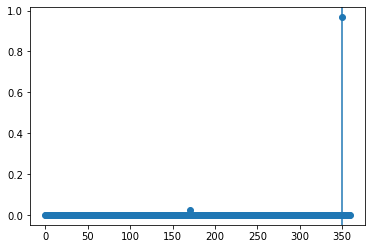

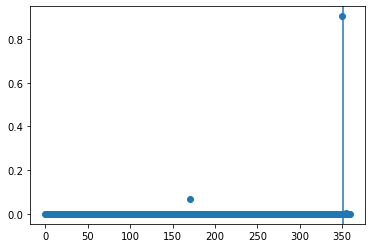

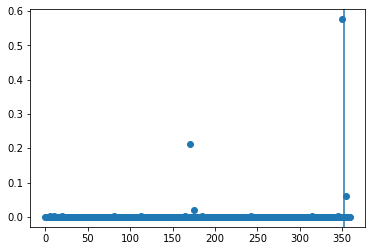

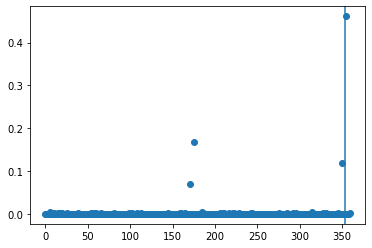

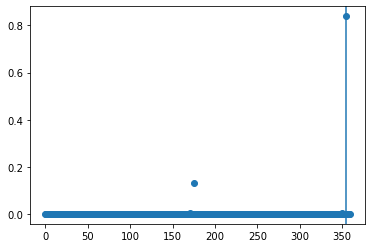

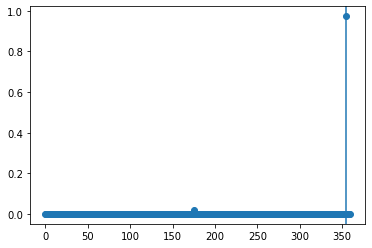

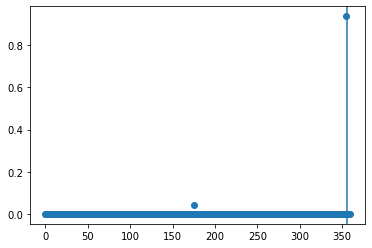

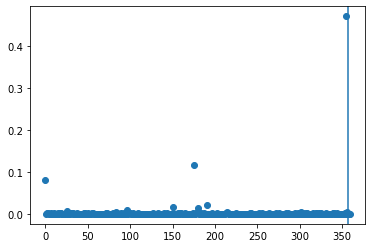

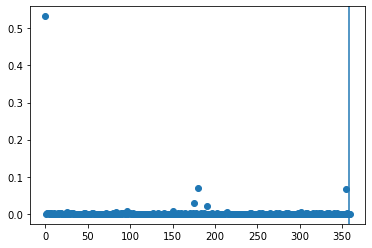

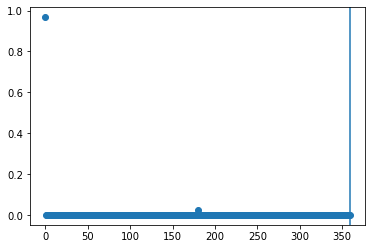

In [8]:
t = [i for i in range(360)]

for i in range(360):
    plt.scatter(t,t_pred[i])
    plt.axvline(t_test[i])
    plt.show()
    plt.close()

In [9]:
diff = [np.argmax(t_pred[i]) - t_test[i] for i in range(360)]

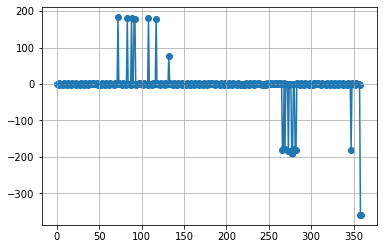

In [10]:
t = [i for i in range(360)]
plt.scatter(t,diff)
plt.plot(t,diff)
plt.grid()
plt.savefig("/home/yoshida/workspace/yoshida/study/picture_for_report/diff_graph.png")

一方向の場合でも照射角度を180度間違えている場合が確認できる。

実際の線量分布の違いについても見る必要がありそう。

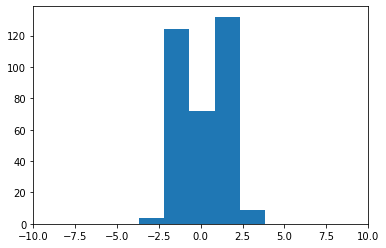

In [11]:
plt.hist(diff, bins = 360)
plt.xlim(-10,10)
plt.savefig("/home/yoshida/workspace/yoshida/study/picture_for_report/diff_hist.png")

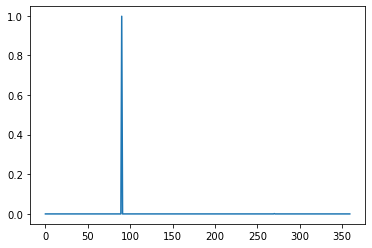

In [48]:
plt.plot(t,t_pred[90])
plt.savefig("/home/yoshida/workspace/yoshida/study/picture_for_report/predict_result_90.png")

In [13]:
file_names = [str(dir_name)+"/"+str(theta)+","+str(phi)+".csv" for theta in theta_s]

data = [np.array(pd.read_csv(file_name)['dose']).reshape(150,61,61) for file_name in file_names]

data = np.array(data).astype("float32")

In [14]:
data[120].shape

(150, 61, 61)

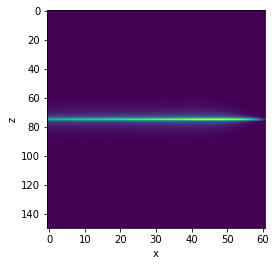

In [47]:

plt.imshow(data[90].sum(2), aspect=61/150)

plt.ylabel("z")
plt.xlabel("x")
plt.savefig("/home/yoshida/workspace/yoshida/study/picture_for_report/input_data_90.png")

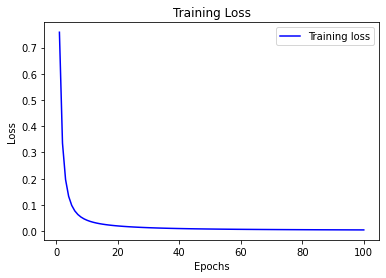

In [20]:
loss_values = history.history['loss']

# エポック数を取得
epochs = range(1, len(loss_values) + 1)

# 損失関数のグラフをプロット
plt.plot(epochs[:100], loss_values[:100], 'b', label='Training loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.savefig("/home/yoshida/workspace/yoshida/study/picture_for_report/train_loss.png")